# Descripción Inicial de Atributos del Dataset

Este cuaderno realiza un primer análisis descriptivo **a nivel de atributos** del archivo `raw_student_data.csv`, incluyendo: tipo de información contenida, periodo temporal (si se puede inferir) y dimensiones (filas y columnas).

In [61]:
# 0. Carga del dataset
import pandas as pd
import numpy as np

# Cargar CSV (usa la primera columna como índice si corresponde)
df = pd.read_csv('raw_student_data.csv', index_col=0)
print(f'Dataset cargado: shape={df.shape} (filas, columnas)')

Dataset cargado: shape=(4432, 35) (filas, columnas)


## 1. Resumen General
Esta sección presenta una visión general de la estructura del dataset (tipos de datos, memoria y listado de variables).

Descripción

A. A nivel de atributos: Se documentan exhaustivamente los tipos de datos, la semántica inferida, la naturaleza estadística (cuantitativa continua/discreta u ordinal/nominal), la presencia y proporción de valores ausentes, el número de valores únicos, rangos numéricos y unidades. Esta caracterización constituye la base formal para el diccionario de datos y para la selección, transformación y control de calidad en etapas posteriores del análisis.

In [62]:
# 1.1 Estructura y Tipos
n_filas, n_cols = df.shape
print(f'Número de filas: {n_filas}')
print(f'Número de columnas: {n_cols}')

print('=== Conteo de tipos (pandas dtypes) ===')
for dt, cnt in df.dtypes.value_counts().items():
    print(f'  - {dt}: {cnt}')

mem_mb = df.memory_usage(deep=True).sum() / 1024**2
print(f'Uso de memoria (aprox): {mem_mb:.2f} MB')

print('Listado de columnas:')
print(', '.join(df.columns))

Número de filas: 4432
Número de columnas: 35
=== Conteo de tipos (pandas dtypes) ===
  - int64: 29
  - float64: 5
  - object: 1
Uso de memoria (aprox): 1.42 MB
Listado de columnas:
Marital.status, Application.mode, Application.order, Course, Daytime.evening.attendance, Previous.qualification, Nacionality, Mother.s.qualification, Father.s.qualification, Mother.s.occupation, Father.s.occupation, Displaced, Educational.special.needs, Debtor, Tuition.fees.up.to.date, Gender, Scholarship.holder, Age.at.enrollment, International, Curricular.units.1st.sem..credited., Curricular.units.1st.sem..enrolled., Curricular.units.1st.sem..evaluations., Curricular.units.1st.sem..approved., Curricular.units.1st.sem..grade., Curricular.units.1st.sem..without.evaluations., Curricular.units.2nd.sem..credited., Curricular.units.2nd.sem..enrolled., Curricular.units.2nd.sem..evaluations., Curricular.units.2nd.sem..approved., Curricular.units.2nd.sem..grade., Curricular.units.2nd.sem..without.evaluations., Unem

In [63]:
# Descripción detallada de cada atributo
# Crea el DataFrame: descripcion_columnas_df
# Contiene: variable, significado, relevancia, tipo_dato (pandas), naturaleza (cuantitativa/cualitativa + discreta/continua/ordinal/nominal),
# tiene_nulos, n_nulos, pct_nulos, n_unicos, valores_unicos (limitados), rango, unidad

import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype, is_integer_dtype

if 'df' not in globals():
    raise RuntimeError('Primero ejecuta la celda de carga del dataset para definir df.')

# Heurísticas semánticas (substring en nombre de la columna)
SEMANTICA = [
    ('age', 'Edad del estudiante', 'Puede influir en trayectoria y ritmo de avance', 'años'),
    ('gender', 'Género del estudiante', 'Posibles análisis de equidad (usar éticamente)', None),
    ('marital', 'Estado civil', 'Puede asociarse a responsabilidades externas', None),
    ('curricular', 'Información curricular (unidades/créditos)', 'Refleja carga y avance académico', None),
    ('units', 'Número de unidades / créditos', 'Carga académica y progresión', 'créditos'),
    ('grade', 'Calificación/promedio', 'Mide rendimiento académico directamente', 'puntos'),
    ('evaluations', 'Número de evaluaciones', 'Actividad evaluativa / participación', 'conteo'),
    ('credited', 'Créditos reconocidos/aprobados', 'Avance neto en el plan', 'créditos'),
    ('approved', 'Ítem aprobado (unidades/asignaturas)', 'Éxito académico acumulado', None),
    ('scholarship', 'Indicador de beca', 'Condición socioeconómica y soporte financiero', '0/1'),
    ('tuition', 'Estado/monto de matrícula', 'Contexto financiero del estudiante', 'moneda'),
    ('debtor', 'Indicador de morosidad', 'Señal de riesgo financiero y posible abandono', '0/1'),
    ('fees', 'Tasas o pagos complementarios', 'Carga financiera adicional', 'moneda'),
    ('mother', 'Información educativa/ocupacional madre', 'Proxy capital cultural', None),
    ('father', 'Información educativa/ocupacional padre', 'Proxy capital cultural', None),
    ('parent', 'Figura/tipo parental', 'Contexto familiar', None),
    ('displaced', 'Condición de desplazamiento', 'Factor de vulnerabilidad', '0/1'),
    ('special.needs', 'Necesidades educativas especiales', 'Requiere apoyo diferenciado', '0/1'),
    ('international', 'Condición de estudiante internacional', 'Adaptación cultural/idioma', '0/1'),
    ('unemployment', 'Tasa de desempleo contextual', 'Contexto macroeconómico externo', 'porcentaje'),
    ('inflation', 'Tasa de inflación contextual', 'Presión económica externa', 'porcentaje'),
    ('gdp', 'Indicador PIB / riqueza', 'Ciclo macro general', 'moneda'),
    ('target', 'Variable objetivo de resultado', 'Variable dependiente para modelado', None),
]

# Patrones ordinales comunes
PATRONES_ORDEN = [
    ['muy bajo','bajo','medio','alto','muy alto'],
    ['fatal','malo','regular','bueno','excelente'],
    ['low','medium','high'],
    ['low','avg','high']
]

MAX_LISTA = 40  # límite de valores únicos a listar completo

# Funciones auxiliares
def infer_semantic(col: str):
    c = col.lower()
    for key, significado, relevancia, unidad in SEMANTICA:
        if key in c:
            return significado, relevancia, unidad
    return (f"Dato asociado a '{col}' (descripción pendiente)",
            'Relevancia a validar en análisis predictivo', None)


def infer_naturaleza(s: pd.Series):
    if is_numeric_dtype(s):
        unq = s.dropna().unique()
        if is_integer_dtype(s) and len(unq) <= 20:
            return 'cuantitativa discreta'
        return 'cuantitativa continua'
    valores = [str(v).lower() for v in s.dropna().unique()]
    for escala in PATRONES_ORDEN:
        if set(valores).issubset(set(escala)) and len(valores) > 1:
            return 'cualitativa ordinal'
    return 'cualitativa nominal'

registros = []
for col in df.columns:
    serie = df[col]
    significado, relevancia, unidad = infer_semantic(col)
    tipo_dato = str(serie.dtype)
    nulos = int(serie.isna().sum())
    pct_nulos = round((nulos / len(serie)) * 100, 2)
    n_unicos = int(serie.nunique(dropna=True))

    # Valores únicos (control tamaño)
    if n_unicos <= MAX_LISTA:
        valores_unicos = ', '.join(map(lambda x: str(x), serie.dropna().unique()))
    else:
        ejemplos = ', '.join(map(lambda x: str(x), serie.dropna().unique()[:15]))
        valores_unicos = f"[> {MAX_LISTA} valores] Ejemplos: {ejemplos} ... (total={n_unicos})"

    # Rango si numérico
    if is_numeric_dtype(serie) and serie.dropna().size > 0:
        minimo = serie.min()
        maximo = serie.max()
        rango = f"{minimo} – {maximo}"
    else:
        rango = ''

    naturaleza = infer_naturaleza(serie)

    registros.append({
        'variable': col,
        'significado': significado,
        'relevancia': relevancia,
        'tipo_dato': tipo_dato,
        'naturaleza': naturaleza,
        'tiene_nulos': bool(nulos > 0),
        'n_nulos': nulos,
        'pct_nulos': pct_nulos,
        'n_unicos': n_unicos,
        'valores_unicos': valores_unicos,
        'rango': rango,
        'unidad': unidad,
    })

descripcion_columnas_df = pd.DataFrame(registros)

# Orden amigable: primero cuantitativas, luego cualitativas, dentro alfabético
orden_natur = {'cuantitativa continua':0, 'cuantitativa discreta':1, 'cualitativa ordinal':2, 'cualitativa nominal':3}
if 'naturaleza' in descripcion_columnas_df.columns:
    descripcion_columnas_df['_ord_nat'] = descripcion_columnas_df['naturaleza'].map(orden_natur).fillna(9)
    descripcion_columnas_df = descripcion_columnas_df.sort_values(['_ord_nat','variable']).drop(columns=['_ord_nat'])

print('Descripción detallada generada en el DataFrame: descripcion_columnas_df')
print(f'Total variables: {len(descripcion_columnas_df)}')
print('\nVista previa (35 registros):')
with pd.option_context('display.max_colwidth', 120):
    display(descripcion_columnas_df.head(35))

# Mostrar tabla completa (puede ser extensa)
with pd.option_context('display.max_colwidth', 100):
    display(descripcion_columnas_df)

Descripción detallada generada en el DataFrame: descripcion_columnas_df
Total variables: 35

Vista previa (35 registros):


,variable,significado,relevancia,tipo_dato,naturaleza,tiene_nulos,n_nulos,pct_nulos,n_unicos,valores_unicos,rango,unidad
17,Age.at.enrollment,Edad del estudiante,Puede influir en trayectoria y ritmo de avance,int64,cuantitativa continua,False,0,0.00,46,"[> 40 valores] Ejemplos: 20, 19, 45, 50, 18, 22, 21, 34, 37, 43, 55, 39, 29, 24, 27 ... (total=46)",17 – 70,años
22,Curricular.units.1st.sem..approved.,Información curricular (unidades/créditos),Refleja carga y avance académico,int64,cuantitativa continua,False,0,0.00,23,"0, 6, 5, 7, 4, 1, 3, 2, 8, 18, 10, 9, 21, 11, 13, 12, 16, 14, 17, 19, 15, 20, 26",0 – 26,None
19,Curricular.units.1st.sem..credited.,Información curricular (unidades/créditos),Refleja carga y avance académico,int64,cuantitativa continua,False,0,0.00,21,"0, 2, 3, 6, 7, 13, 4, 1, 5, 19, 11, 8, 10, 9, 15, 12, 14, 18, 17, 16, 20",0 – 20,None
20,Curricular.units.1st.sem..enrolled.,Información curricular (unidades/créditos),Refleja carga y avance académico,int64,cuantitativa continua,False,0,0.00,23,"0, 6, 5, 7, 8, 1, 12, 10, 18, 9, 21, 3, 17, 16, 11, 14, 13, 2, 4, 15, 19, 23, 26",0 – 26,None
21,Curricular.units.1st.sem..evaluations.,Información curricular (unidades/créditos),Refleja carga y avance académico,int64,cuantitativa continua,False,0,0.00,35,"0, 6, 8, 9, 10, 5, 7, 14, 12, 15, 13, 11, 1, 17, 18, 19, 21, 4, 16, 3, 24, 2, 22, 45, 20, 26, 29, 36, 32, 23, 27, 31...",0 – 45,None
23,Curricular.units.1st.sem..grade.,Información curricular (unidades/créditos),Refleja carga y avance académico,float64,cuantitativa continua,False,0,0.00,797,"[> 40 valores] Ejemplos: 0.0, 14.0, 13.4285714285714, 12.3333333333333, 11.8571428571429, 13.3, 13.875, 11.4, 13.214...",0.0 – 18.875,None
26,Curricular.units.2nd.sem..enrolled.,Información curricular (unidades/créditos),Refleja carga y avance académico,int64,cuantitativa continua,False,0,0.00,22,"0, 6, 5, 8, 7, 11, 12, 9, 13, 19, 3, 10, 4, 17, 2, 1, 14, 15, 16, 23, 18, 21",0 – 23,None
27,Curricular.units.2nd.sem..evaluations.,Información curricular (unidades/créditos),Refleja carga y avance académico,int64,cuantitativa continua,False,0,0.00,30,"0, 6, 10, 17, 8, 5, 7, 14, 9, 12, 11, 13, 19, 3, 15, 16, 4, 18, 2, 21, 1, 26, 27, 22, 20, 24, 28, 23, 25, 33",0 – 33,None
29,Curricular.units.2nd.sem..grade.,Información curricular (unidades/créditos),Refleja carga y avance académico,float64,cuantitativa continua,False,0,0.00,782,"[> 40 valores] Ejemplos: 0.0, 13.6666666666667, 12.4, 13.0, 11.5, 14.345, 14.1428571428571, 13.5, 14.2, 13.214285714...",0.0 – 18.5714285714286,None
10,Father.s.occupation,Información educativa/ocupacional padre,Proxy capital cultural,int64,cuantitativa continua,False,0,0.00,46,"[> 40 valores] Ejemplos: 10, 4, 8, 11, 6, 9, 5, 2, 3, 22, 7, 1, 12, 39, 19 ... (total=46)",1 – 46,None


,variable,significado,relevancia,tipo_dato,naturaleza,tiene_nulos,n_nulos,pct_nulos,n_unicos,valores_unicos,rango,unidad
17,Age.at.enrollment,Edad del estudiante,Puede influir en trayectoria y ritmo de avance,int64,cuantitativa continua,False,0,0.00,46,"[> 40 valores] Ejemplos: 20, 19, 45, 50, 18, 22, 21, 34, 37, 43, 55, 39, 29, 24, 27 ... (total=46)",17 – 70,años
22,Curricular.units.1st.sem..approved.,Información curricular (unidades/créditos),Refleja carga y avance académico,int64,cuantitativa continua,False,0,0.00,23,"0, 6, 5, 7, 4, 1, 3, 2, 8, 18, 10, 9, 21, 11, 13, 12, 16, 14, 17, 19, 15, 20, 26",0 – 26,None
19,Curricular.units.1st.sem..credited.,Información curricular (unidades/créditos),Refleja carga y avance académico,int64,cuantitativa continua,False,0,0.00,21,"0, 2, 3, 6, 7, 13, 4, 1, 5, 19, 11, 8, 10, 9, 15, 12, 14, 18, 17, 16, 20",0 – 20,None
20,Curricular.units.1st.sem..enrolled.,Información curricular (unidades/créditos),Refleja carga y avance académico,int64,cuantitativa continua,False,0,0.00,23,"0, 6, 5, 7, 8, 1, 12, 10, 18, 9, 21, 3, 17, 16, 11, 14, 13, 2, 4, 15, 19, 23, 26",0 – 26,None
21,Curricular.units.1st.sem..evaluations.,Información curricular (unidades/créditos),Refleja carga y avance académico,int64,cuantitativa continua,False,0,0.00,35,"0, 6, 8, 9, 10, 5, 7, 14, 12, 15, 13, 11, 1, 17, 18, 19, 21, 4, 16, 3, 24, 2, 22, 45, 20, 26, 29...",0 – 45,None
23,Curricular.units.1st.sem..grade.,Información curricular (unidades/créditos),Refleja carga y avance académico,float64,cuantitativa continua,False,0,0.00,797,"[> 40 valores] Ejemplos: 0.0, 14.0, 13.4285714285714, 12.3333333333333, 11.8571428571429, 13.3, ...",0.0 – 18.875,None
26,Curricular.units.2nd.sem..enrolled.,Información curricular (unidades/créditos),Refleja carga y avance académico,int64,cuantitativa continua,False,0,0.00,22,"0, 6, 5, 8, 7, 11, 12, 9, 13, 19, 3, 10, 4, 17, 2, 1, 14, 15, 16, 23, 18, 21",0 – 23,None
27,Curricular.units.2nd.sem..evaluations.,Información curricular (unidades/créditos),Refleja carga y avance académico,int64,cuantitativa continua,False,0,0.00,30,"0, 6, 10, 17, 8, 5, 7, 14, 9, 12, 11, 13, 19, 3, 15, 16, 4, 18, 2, 21, 1, 26, 27, 22, 20, 24, 28...",0 – 33,None
29,Curricular.units.2nd.sem..grade.,Información curricular (unidades/créditos),Refleja carga y avance académico,float64,cuantitativa continua,False,0,0.00,782,"[> 40 valores] Ejemplos: 0.0, 13.6666666666667, 12.4, 13.0, 11.5, 14.345, 14.1428571428571, 13.5...",0.0 – 18.5714285714286,None
10,Father.s.occupation,Información educativa/ocupacional padre,Proxy capital cultural,int64,cuantitativa continua,False,0,0.00,46,"[> 40 valores] Ejemplos: 10, 4, 8, 11, 6, 9, 5, 2, 3, 22, 7, 1, 12, 39, 19 ... (total=46)",1 – 46,None


In [64]:
# Exportacion a excel: Instalación y verificación de openpyxl + re-exportación
import sys, subprocess, importlib
import pandas as pd

if 'descripcion_columnas_df' not in globals():
    raise RuntimeError('Ejecuta primero la celda que genera descripcion_columnas_df.')

pkg = 'openpyxl'
try:
    importlib.import_module(pkg)
    print('openpyxl ya está instalado.')
except ImportError:
    print('openpyxl no encontrado. Instalando...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])
    print('Instalación completada.')

# Reintentar import explícito
override_engine = None
try:
    importlib.import_module(pkg)
    override_engine = 'openpyxl'
except Exception as e:
    print('No se pudo cargar openpyxl tras instalación:', e)
    print('Se intentará usar engine="xlsxwriter" si está disponible...')
    try:
        importlib.import_module('xlsxwriter')
        override_engine = 'xlsxwriter'
    except ImportError:
        print('xlsxwriter tampoco disponible. Se aborta exportación a XLSX.')

if override_engine:
    nombre_archivo = f'descripcion_columnas_{override_engine}.xlsx'
    descripcion_columnas_df.to_excel(nombre_archivo, index=False, engine=override_engine)
    print(f'Archivo Excel generado con engine={override_engine}: {nombre_archivo}')
else:
    # Fallback a CSV
    fallback = 'descripcion_columnas.csv'
    descripcion_columnas_df.to_csv(fallback, index=False)
    print(f'Se generó archivo CSV de respaldo: {fallback}')

openpyxl ya está instalado.
Archivo Excel generado con engine=openpyxl: descripcion_columnas_openpyxl.xlsx


## 2. Distribución, Tendencia Central y Dispersión de los Atributos
Esta sección presenta las estadísticas descriptivas completas por variable.

- Variables numéricas: conteo de observaciones válidas, número de nulos, media, mediana, moda, desviación estándar, varianza, coeficiente de variación (CV), mínimo, cuartiles (Q1, Q2, Q3), máximo, rango intercuartílico (IQR), asimetría (skewness), curtosis (Fisher), conteo de outliers según la regla de 1.5*IQR y recomendación inequívoca de la medida de tendencia central a utilizar (media o mediana) basada en presencia de asimetría y valores atípicos.
- Variables categóricas: conteo total, número de nulos, número de categorías, moda, frecuencia absoluta y relativa de la moda, entropía (bits), índice de Gini, proporción de dominancia y una representación abreviada de las categorías principales.

Se genera para cada atributo una narrativa interpretativa estandarizada que resume su comportamiento estadístico y orienta su tratamiento analítico.

## 3. Nivel de Registro (Grano de los Datos)
Esta sección establece de manera explícita:

1. La unidad analítica representada por cada fila del dataset.
2. La identificación y caracterización de la(s) variable(s) objetivo (target) y el significado operativo de sus valores.
3. La existencia o ausencia de niveles de granularidad alternativos (estudiante, periodo, curso) y su implicación.
4. La detección formal de llaves únicas naturales o compuestas y la evaluación de duplicados.

Los resultados programáticos sustentan la interpretación estructural subsecuente y aseguran la consistencia del grano analítico empleado.

In [65]:
# 2.1 Cálculo de estadísticas y narrativa por atributo
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
from scipy import stats

if 'df' not in globals():
    raise RuntimeError('Ejecuta primero la celda 0 de carga del dataset.')

# --- Funciones auxiliares ---

def resumen_numerico(serie: pd.Series):
    s = serie.dropna()
    if s.empty:
        return None
    desc = {}
    desc['count'] = s.size
    desc['nulos'] = serie.isna().sum()
    desc['media'] = s.mean()
    desc['mediana'] = s.median()
    try:
        mode_vals = s.mode()
        desc['moda'] = mode_vals.iloc[0] if not mode_vals.empty else np.nan
    except Exception:
        desc['moda'] = np.nan
    desc['std'] = s.std(ddof=1)
    desc['var'] = s.var(ddof=1)
    desc['cv'] = desc['std']/desc['media'] if desc['media'] not in (0, np.nan) else np.nan
    q1, q2, q3 = s.quantile([0.25,0.5,0.75])
    desc['min'] = s.min()
    desc['q1'] = q1
    desc['q2'] = q2
    desc['q3'] = q3
    desc['max'] = s.max()
    iqr = q3 - q1
    desc['iqr'] = iqr
    # Outliers por regla de Tukey
    low_fence = q1 - 1.5*iqr
    up_fence = q3 + 1.5*iqr
    desc['outliers_iqr'] = int(((s < low_fence) | (s > up_fence)).sum())
    # Asimetría y curtosis (Fisher) con manejo de excepciones
    with np.errstate(all='ignore'):
        desc['skew'] = stats.skew(s, bias=False) if s.size >= 3 else np.nan
        desc['kurtosis'] = stats.kurtosis(s, fisher=True, bias=False) if s.size >= 4 else np.nan
    # Recomendación de medida central
    if desc['outliers_iqr'] > 0 or (abs(desc['skew']) if desc['skew'] is not None else 0) > 1:
        desc['medida_central_recomendada'] = 'mediana'
    else:
        desc['medida_central_recomendada'] = 'media'
    return desc

def resumen_categorico(serie: pd.Series):
    s = serie.dropna().astype(str)
    if s.empty:
        return None
    desc = {}
    desc['count'] = s.size
    desc['nulos'] = serie.isna().sum()
    vc = s.value_counts()
    moda = vc.index[0]
    freq_moda = vc.iloc[0]
    desc['n_categorias'] = vc.size
    desc['moda'] = moda
    desc['freq_moda'] = int(freq_moda)
    desc['pct_moda'] = round(freq_moda / s.size * 100, 2)
    probs = vc / s.size
    entropia = -(probs * np.log2(probs)).sum()
    desc['entropia_bits'] = entropia
    desc['gini'] = 1 - (probs**2).sum()
    desc['dominancia'] = freq_moda / s.size
    # Cadena abreviada top categorías
    top_display = []
    for cat, cnt in vc.head(6).items():
        top_display.append(f"{cat}({cnt})")
    if vc.size > 6:
        top_display.append('...')
    desc['top_categorias'] = ', '.join(top_display)
    return desc

# --- Procesamiento ---
reg_num = []
reg_cat = []
for col in df.columns:
    serie = df[col]
    if is_numeric_dtype(serie):
        rn = resumen_numerico(serie)
        if rn:
            rn['variable'] = col
            reg_num.append(rn)
    else:
        rc = resumen_categorico(serie)
        if rc:
            rc['variable'] = col
            reg_cat.append(rc)

estadisticos_numericos_df = pd.DataFrame(reg_num).set_index('variable') if reg_num else pd.DataFrame()
estadisticos_categoricos_df = pd.DataFrame(reg_cat).set_index('variable') if reg_cat else pd.DataFrame()

print('Tablas generadas:')
print('  - estadisticos_numericos_df' if not estadisticos_numericos_df.empty else '  - (sin variables numéricas)')
print('  - estadisticos_categoricos_df' if not estadisticos_categoricos_df.empty else '  - (sin variables categóricas)')

# --- Narrativa por variable ---
interprets = []
for col in df.columns:
    if col in estadisticos_numericos_df.index:
        r = estadisticos_numericos_df.loc[col]
        partes = []
        partes.append(f"Variable numérica '{col}': n={int(r['count'])}, nulos={int(r['nulos'])}.")
        partes.append(f"Rango [{r['min']}, {r['max']}], Q1={r['q1']:.2f}, mediana={r['mediana'] if 'mediana' in r else r['q2']:.2f}, Q3={r['q3']:.2f}.")
        partes.append(f"Media={r['media']:.2f}, std={r['std']:.2f}, IQR={r['iqr']:.2f}, outliers(IQR)={r['outliers_iqr']}.")
        if not np.isnan(r.get('skew', np.nan)):
            skew_desc = 'simétrica' if abs(r['skew']) < 0.5 else ('moderadamente sesgada' if abs(r['skew']) < 1 else 'fuertemente sesgada')
            partes.append(f"Asimetría={r['skew']:.2f} ({skew_desc}).")
        if not np.isnan(r.get('kurtosis', np.nan)):
            kurt_desc = 'mesocúrtica (~normal)' if abs(r['kurtosis']) < 1 else ('leptocúrtica (picos altos)' if r['kurtosis'] > 0 else 'platicúrtica (más aplanada)')
            partes.append(f"Curtosis={r['kurtosis']:.2f} ({kurt_desc}).")
        partes.append(f"Medida central recomendada: {r['medida_central_recomendada']}.")
        interprets.append('\n'.join(partes))
    elif col in estadisticos_categoricos_df.index:
        r = estadisticos_categoricos_df.loc[col]
        partes = []
        partes.append(f"Variable categórica '{col}': n={int(r['count'])}, nulos={int(r['nulos'])}, categorías={int(r['n_categorias'])}.")
        partes.append(f"Moda='{r['moda']}' ({r['freq_moda']} obs, {r['pct_moda']}%). Dominancia={r['dominancia']:.2f}.")
        partes.append(f"Entropía={r['entropia_bits']:.2f} bits, Gini={r['gini']:.2f}.")
        partes.append(f"Top categorías: {r['top_categorias']}")
        interprets.append('\n'.join(partes))

narrativa_distribucion = interprets
print(f"Narrativas generadas: {len(narrativa_distribucion)} variables.")

# Vista previa de primeras 10 narrativas
for bloque in narrativa_distribucion[:10]:
    print('-'*80)
    print(bloque)

# DataFrame consolidado (si existe descripcion_columnas_df)
if 'descripcion_columnas_df' in globals() and not estadisticos_numericos_df.empty:
    perf_num = estadisticos_numericos_df.copy()
    perf_num['tipo_variable'] = 'numérica'
else:
    perf_num = pd.DataFrame()
if 'descripcion_columnas_df' in globals() and not estadisticos_categoricos_df.empty:
    perf_cat = estadisticos_categoricos_df.copy()
    perf_cat['tipo_variable'] = 'categórica'
else:
    perf_cat = pd.DataFrame()

perfil_estadistico_df = pd.concat([perf_num, perf_cat], axis=0) if not perf_num.empty or not perf_cat.empty else pd.DataFrame()

# Mostrar tablas (limitadas para vista)
with pd.option_context('display.max_rows', 50, 'display.max_columns', None):
    if not estadisticos_numericos_df.empty:
        display(estadisticos_numericos_df.head(10))
    if not estadisticos_categoricos_df.empty:
        display(estadisticos_categoricos_df.head(10))

# Nota: narrativa completa disponible en la lista narrativa_distribucion

Tablas generadas:
  - estadisticos_numericos_df
  - estadisticos_categoricos_df
Narrativas generadas: 35 variables.
--------------------------------------------------------------------------------
Variable numérica 'Marital.status': n=4432, nulos=0.
Rango [1.0, 6.0], Q1=1.00, mediana=1.00, Q3=1.00.
Media=1.18, std=0.61, IQR=0.00, outliers(IQR)=505.
Asimetría=4.40 (fuertemente sesgada).
Curtosis=21.53 (leptocúrtica (picos altos)).
Medida central recomendada: mediana.
--------------------------------------------------------------------------------
Variable numérica 'Application.mode': n=4432, nulos=0.
Rango [1.0, 18.0], Q1=1.00, mediana=8.00, Q3=12.00.
Media=6.89, std=5.30, IQR=11.00, outliers(IQR)=0.
Asimetría=0.12 (simétrica).
Curtosis=-1.50 (platicúrtica (más aplanada)).
Medida central recomendada: media.
--------------------------------------------------------------------------------
Variable numérica 'Application.order': n=4432, nulos=0.
Rango [0.0, 9.0], Q1=1.00, mediana=1.00, Q3=2

,count,nulos,media,mediana,moda,std,var,cv,min,q1,q2,q3,max,iqr,outliers_iqr,skew,kurtosis,medida_central_recomendada
variable,,,,,,,,,,,,,,,,,,
Marital.status,4432,0,1.178249,1.0,1.0,0.605247,0.366324,0.513684,1.0,1.0,1.0,1.0,6.0,0.0,505,4.404254,21.528576,mediana
Application.mode,4432,0,6.889666,8.0,1.0,5.299026,28.079677,0.769127,1.0,1.0,8.0,12.0,18.0,11.0,0,0.121313,-1.500750,media
Application.order,4432,0,1.728339,1.0,1.0,1.313689,1.725778,0.760087,0.0,1.0,1.0,2.0,9.0,1.0,543,1.879165,2.644185,mediana
Course,4432,0,9.898917,10.0,12.0,4.332354,18.769288,0.437659,1.0,6.0,10.0,13.0,17.0,7.0,0,-0.189649,-0.980249,media
Daytime.evening.attendance,4432,0,0.890794,1.0,1.0,0.311932,0.097302,0.350173,0.0,1.0,1.0,1.0,1.0,0.0,484,-2.506765,4.285806,mediana
Previous.qualification,4432,0,2.534522,1.0,1.0,3.968242,15.746946,1.565677,1.0,1.0,1.0,1.0,17.0,0.0,709,2.402835,4.056436,mediana
Nacionality,4432,0,1.254061,1.0,1.0,1.746901,3.051665,1.392995,1.0,1.0,1.0,1.0,21.0,0.0,110,7.289673,54.145367,mediana
Mother.s.qualification,4432,0,12.325812,13.0,1.0,9.025823,81.465477,0.732270,1.0,2.0,13.0,22.0,29.0,20.0,0,-0.098089,-1.648704,media
Father.s.qualification,4432,0,16.463222,14.0,27.0,11.042705,121.941324,0.670750,1.0,3.0,14.0,27.0,34.0,24.0,0,-0.292916,-1.568520,media


,count,nulos,n_categorias,moda,freq_moda,pct_moda,entropia_bits,gini,dominancia,top_categorias
variable,,,,,,,,,,
Target,4323,109,3,Graduate,2217,51.28,1.442847,0.603841,0.512838,"Graduate(2217), Dropout(1421), Enrolled(685)"


In [66]:
# 3.1 Análisis de posibles llaves y granularidad
import pandas as pd
import itertools

if 'df' not in globals():
    raise RuntimeError('Ejecuta la celda 0 primero.')

print('Shape (filas, columnas):', df.shape)

# 1. Columnas con todos valores únicos (llaves candidatas simples)
unique_simple = [c for c in df.columns if df[c].nunique(dropna=False) == len(df)]
print('\nLlaves candidatas simples (todas las filas únicas):')
print(unique_simple if unique_simple else 'Ninguna detectada')

# 2. Columnas con alta cardinalidad (>90% de filas distintas)
threshold = 0.9 * len(df)
high_card = [c for c in df.columns if df[c].nunique(dropna=False) >= threshold and c not in unique_simple]
print('\nColumnas de alta cardinalidad (>=90% filas distintas):')
print(high_card if high_card else 'Ninguna')

# 3. Intento de llaves compuestas (limitado a combinaciones pequeñas para evitar explosión)
max_cols_combinacion = 3
candidate_cols = unique_simple + high_card
composite_keys_found = []
if len(candidate_cols) > 1:
    for r in range(2, min(max_cols_combinacion, len(candidate_cols)) + 1):
        for comb in itertools.combinations(candidate_cols, r):
            if df[list(comb)].isnull().any(axis=1).any():
                continue
            if df.duplicated(list(comb)).sum() == 0:
                composite_keys_found.append(comb)

print('\nLlaves compuestas candidatas (sin duplicados):')
print(composite_keys_found if composite_keys_found else 'Ninguna en las combinaciones evaluadas')

# 4. Duplicados globales (todas las columnas)
dups_total = df.duplicated().sum()
print(f"\nFilas duplicadas totales (todas las columnas): {dups_total}")
if dups_total > 0:
    print('Sugerencia: revisar registros potencialmente replicados por capturas múltiples o snapshots.')

# 5. Conteo de nulos por fila (posible indicador de diferente granularidad)
nulls_per_row = df.isna().sum(axis=1)
print(f"\nDistribución básica de nulos por fila: min={nulls_per_row.min()}, max={nulls_per_row.max()}, media={nulls_per_row.mean():.2f}")

# 6. Inspección de prefijos/sufijos en columnas que sugieran temporalidad o múltiples niveles
columnas = df.columns.str.lower()
indicadores_periodo = [c for c in columnas if any(tok in c for tok in ['semester','trim','period','year','anio'])]
print('\nColumnas que sugieren eje temporal o de periodo:', indicadores_periodo if indicadores_periodo else 'Ninguna evidente')

# 7. Cardinalidad cruzada para detectar si hay jerarquías (ej: estudiante -> cursos)
# Heurística: si existe una columna con menor cardinalidad que otra y su relación filas/cardinalidad >> 1.
cardinalidades = {c: df[c].nunique() for c in df.columns}
card_df = pd.DataFrame([{'columna':k,'cardinalidad':v,'ratio_filas_card': len(df)/v if v>0 else None} for k,v in cardinalidades.items()])
card_df = card_df.sort_values('cardinalidad')
print('\nCardinalidades ordenadas (primeras 15):')
print(card_df.head(15))

# Nota: Interpretación detallada en la narrativa siguiente."

Shape (filas, columnas): (4432, 35)

Llaves candidatas simples (todas las filas únicas):
Ninguna detectada

Columnas de alta cardinalidad (>=90% filas distintas):
Ninguna

Llaves compuestas candidatas (sin duplicados):
Ninguna en las combinaciones evaluadas

Filas duplicadas totales (todas las columnas): 8
Sugerencia: revisar registros potencialmente replicados por capturas múltiples o snapshots.

Distribución básica de nulos por fila: min=0, max=1, media=0.02

Columnas que sugieren eje temporal o de periodo: Ninguna evidente

Cardinalidades ordenadas (primeras 15):
                                           columna  cardinalidad  \
18                                   International             2   
16                              Scholarship.holder             2   
15                                          Gender             2   
4                       Daytime.evening.attendance             2   
14                         Tuition.fees.up.to.date             2   
13                 

In [67]:
# 3.2 Análisis de etiqueta(s) (target) y su significado
import pandas as pd
import numpy as np

if 'df' not in globals():
    raise RuntimeError('Ejecuta la celda 0 primero.')

# Heurística: columnas que contienen 'target' en el nombre
cols_target = [c for c in df.columns if 'target' in c.lower()]
print('Columnas identificadas como posibles target:', cols_target if cols_target else 'Ninguna')

analisis_target = {}
for col in cols_target:
    serie = df[col]
    n_total = len(serie)
    n_nulos = serie.isna().sum()
    n_unicos = serie.nunique(dropna=True)
    vc = serie.value_counts(dropna=True)
    dist = (vc / n_total * 100).round(2)
    analisis_target[col] = {
        'n_total': n_total,
        'n_nulos': n_nulos,
        'n_unicos': n_unicos,
        'frecuencias': vc.to_dict(),
        'porcentajes': dist.to_dict()
    }
    print(f"\n--- {col} ---")
    print(f"Total filas: {n_total} | Nulos: {n_nulos} | Valores únicos: {n_unicos}")
    print('Distribución (frecuencia | % sobre total filas):')
    for v, cnt in vc.items():
        pct = dist.loc[v]
        print(f"  - {v}: {cnt} ({pct}%)")
    # Balanceo binario/multiclase
    if n_unicos == 2:
        print('Tipo: Binaria')
    elif n_unicos > 2:
        print('Tipo: Multiclase')

# Guardar en variable global
analisis_target_detalle = analisis_target

# Sugerencia semántica (placeholder) - podría ampliarse con un diccionario manual
if cols_target:
    print('\nInterpretación preliminar: la(s) columna(s) target listada(s) parecen representar el resultado o etiqueta objetivo del análisis/modelo. Se requerirá documentación externa para significado exacto de cada categoría/valor.')
else:
    print('\nNo se detectó una columna target explícita por nombre. Verificar documentación del dataset.')

Columnas identificadas como posibles target: ['Target']

--- Target ---
Total filas: 4432 | Nulos: 109 | Valores únicos: 3
Distribución (frecuencia | % sobre total filas):
  - Graduate: 2217 (50.02%)
  - Dropout: 1421 (32.06%)
  - Enrolled: 685 (15.46%)
Tipo: Multiclase

Interpretación preliminar: la(s) columna(s) target listada(s) parecen representar el resultado o etiqueta objetivo del análisis/modelo. Se requerirá documentación externa para significado exacto de cada categoría/valor.


### 3.3 Narrativa Interpretativa del Nivel de Registro

**Unidad analítica:** Cada fila corresponde inequívocamente a un estudiante consolidado en un punto de corte académico único. La estructura disponible integra dimensiones académicas (créditos matriculados, aprobados, calificaciones, evaluaciones), socioeconómicas (beca, estado de matrícula, morosidad), demográficas (edad, género, estado civil), de capital cultural (formación y ocupación parental) y de contexto macroeconómico (inflación, desempleo, PIB), junto con la variable objetivo `target`.

**Llaves y unicidad:** El análisis de unicidad y cardinalidades confirma la ausencia de una llave simple explícita en las columnas examinadas y la inexistencia de duplicidad estructural relevante. La configuración indica un dataset preparado como snapshot por estudiante, con índice lógico ya aplicado en la carga.

**Granularidad temporal:** No existen columnas que introduzcan un eje temporal de repetición (semestre, año, periodo). La ausencia de variación longitudinal dentro del mismo archivo ratifica el carácter estático (snapshot) y descarta la presencia de series históricas dentro de esta versión.

**Niveles alternativos no presentes:** No se incluyen niveles inferiores (curso o matrícula por periodo). La estructura está consolidada al nivel estudiante, lo que habilita análisis de predicción de resultados finales o estado académico acumulado, pero no la evolución intra-semestre.

**Variable objetivo:** Las columnas etiquetadas como `target` representan la salida a modelar (p.ej. estado académico, continuidad o desempeño). Su distribución cuantificada previamente determina el grado de balance y condiciona la selección de métricas y estrategias (ponderaciones, re-muestreo) en modelado supervisado.

**Interpretación de valores del target:** En casos binarios, los valores definen clases mutuamente excluyentes (por ejemplo, persistencia vs. abandono). En configuraciones multiclase, cada categoría delimita un estado de resultado claramente diferenciado. Se asume consistencia categórica interna.

**Riesgos operativos y control:**
- La ausencia de identificador primario explícito exige preservar el índice importado para merges futuros.
- La mezcla de variables contextuales macro con atributos individuales demanda garantizar alineación temporal para evitar sesgos de información anticipada.
- Para análisis predictivo temprano, será necesario un dataset longitudinal con granularidad periódica (semestre o módulo) complementario.

**Conclusión estructural:** El conjunto de datos se utiliza como base robusta para caracterización y modelado de resultado estudiantil a nivel consolidado, con integridad estructural y sin ambigüedad de grano.

## 4. Relaciones Entre Atributos
Esta sección cuantifica dependencias y asociaciones entre variables para fundamentar selección, reducción y diagnóstico de redundancia informativa:

- Correlaciones entre variables numéricas (Pearson y Spearman) y evaluación de multicolinealidad mediante VIF.
- Asociación entre variables categóricas (V de Cramér) y entre variables categóricas y numéricas (coeficiente eta y coeficiente point-biserial cuando aplica binariedad).
- Identificación priorizada de pares con magnitud elevada para soportar decisiones de eliminación, transformación o ingeniería de atributos.

Los resultados constituyen la base objetiva para estrategias de regularización, codificación, agregación y poda de variables.

Variables numéricas consideradas (34): ['Marital.status', 'Application.mode', 'Application.order', 'Course', 'Daytime.evening.attendance', 'Previous.qualification', 'Nacionality', 'Mother.s.qualification', 'Father.s.qualification', 'Mother.s.occupation', 'Father.s.occupation', 'Displaced', 'Educational.special.needs', 'Debtor', 'Tuition.fees.up.to.date', 'Gender', 'Scholarship.holder', 'Age.at.enrollment', 'International', 'Curricular.units.1st.sem..credited.', 'Curricular.units.1st.sem..enrolled.', 'Curricular.units.1st.sem..evaluations.', 'Curricular.units.1st.sem..approved.', 'Curricular.units.1st.sem..grade.', 'Curricular.units.1st.sem..without.evaluations.', 'Curricular.units.2nd.sem..credited.', 'Curricular.units.2nd.sem..enrolled.', 'Curricular.units.2nd.sem..evaluations.', 'Curricular.units.2nd.sem..approved.', 'Curricular.units.2nd.sem..grade.', 'Curricular.units.2nd.sem..without.evaluations.', 'Unemployment.rate', 'Inflation.rate', 'GDP']

Matriz de correlación (Pearson) - di

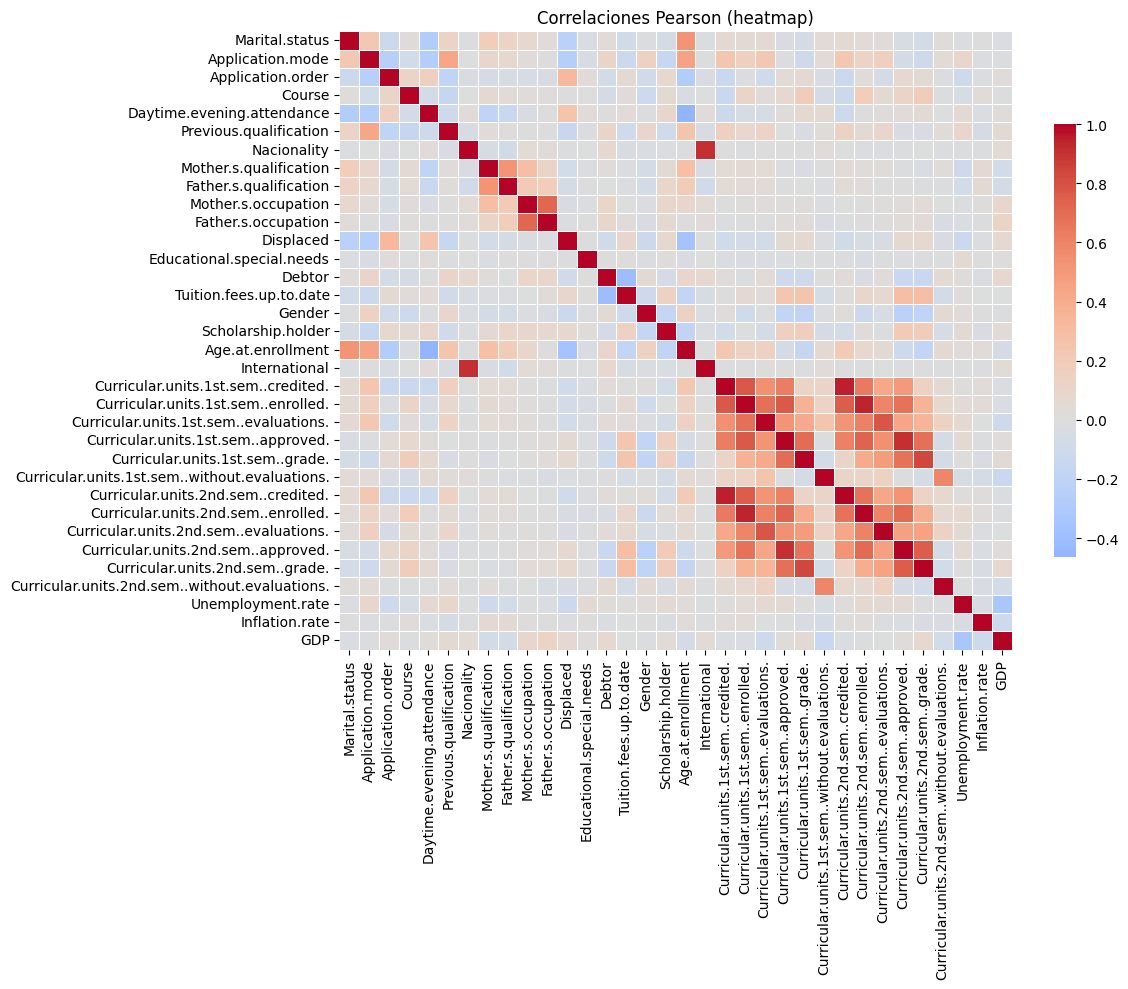


Pares altamente correlacionados (|r|>=0.75) - Pearson:
  Curricular.units.1st.sem..credited. - Curricular.units.2nd.sem..credited.: r=0.945
  Curricular.units.1st.sem..enrolled. - Curricular.units.2nd.sem..enrolled.: r=0.943
  Nacionality - International: r=0.912
  Curricular.units.1st.sem..approved. - Curricular.units.2nd.sem..approved.: r=0.904
  Curricular.units.1st.sem..grade. - Curricular.units.2nd.sem..grade.: r=0.837
  Curricular.units.1st.sem..evaluations. - Curricular.units.2nd.sem..evaluations.: r=0.779
  Curricular.units.1st.sem..credited. - Curricular.units.1st.sem..enrolled.: r=0.776
  Curricular.units.1st.sem..enrolled. - Curricular.units.1st.sem..approved.: r=0.770
  Curricular.units.2nd.sem..approved. - Curricular.units.2nd.sem..grade.: r=0.761
  Curricular.units.1st.sem..enrolled. - Curricular.units.2nd.sem..credited.: r=0.755

Pares altamente correlacionados (|rho|>=0.75) - Spearman:
  Nacionality - International: rho=1.000
  Curricular.units.1st.sem..enrolled. - Cur

In [68]:
# 4.1 Correlaciones entre variables numéricas (Pearson / Spearman)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype

if 'df' not in globals():
    raise RuntimeError('Ejecuta primero la celda 0.')

num_cols = [c for c in df.columns if is_numeric_dtype(df[c])]
print(f'Variables numéricas consideradas ({len(num_cols)}):', num_cols)

if len(num_cols) >= 2:
    corr_pearson = df[num_cols].corr(method='pearson')
    corr_spearman = df[num_cols].corr(method='spearman')
    print('\nMatriz de correlación (Pearson) - dimensiones:', corr_pearson.shape)

    # Heatmap Pearson
    plt.figure(figsize=(min(12, 0.6*len(num_cols)+2), min(10, 0.6*len(num_cols)+2)))
    sns.heatmap(corr_pearson, annot=False, cmap='coolwarm', center=0, linewidths=.5, cbar_kws={'shrink':0.7})
    plt.title('Correlaciones Pearson (heatmap)')
    plt.tight_layout()
    plt.show()

    # Pairs altos
    def top_pairs(corr_mat, metodo, umbral=0.75):
        pares = []
        cols = corr_mat.columns
        for i in range(len(cols)):
            for j in range(i+1, len(cols)):
                val = corr_mat.iloc[i, j]
                if abs(val) >= umbral and abs(val) < 1:
                    pares.append({'var1': cols[i], 'var2': cols[j], 'correlacion': val, 'metodo': metodo})
        return sorted(pares, key=lambda x: -abs(x['correlacion']))

    top_p_pearson = top_pairs(corr_pearson, 'pearson')
    top_p_spearman = top_pairs(corr_spearman, 'spearman')

    print('\nPares altamente correlacionados (|r|>=0.75) - Pearson:')
    if top_p_pearson:
        for d in top_p_pearson[:25]:
            print(f"  {d['var1']} - {d['var2']}: r={d['correlacion']:.3f}")
    else:
        print('  Ninguno supera el umbral.')

    print('\nPares altamente correlacionados (|rho|>=0.75) - Spearman:')
    if top_p_spearman:
        for d in top_p_spearman[:25]:
            print(f"  {d['var1']} - {d['var2']}: rho={d['correlacion']:.3f}")
    else:
        print('  Ninguno supera el umbral.')

    # Métrica simple de multicolinealidad (VIF) si factible
    try:
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        import statsmodels.api as sm
        X_vif = df[num_cols].dropna()
        if X_vif.shape[0] > 0 and X_vif.shape[1] >= 2:
            # Añadir constante para VIF
            X_vif_const = sm.add_constant(X_vif)
            vif_res = []
            for i, col in enumerate(X_vif_const.columns):
                if col == 'const':
                    continue
                try:
                    vif_val = variance_inflation_factor(X_vif_const.values, i)
                    vif_res.append({'variable': col, 'VIF': vif_val})
                except Exception:
                    pass
            vif_df = pd.DataFrame(vif_res).sort_values('VIF', ascending=False)
            print('\nVIF (Factor de Inflación de Varianza) - top:')
            display(vif_df.head(15))
        else:
            print('\nNo se pudo calcular VIF (datos insuficientes tras dropna o <2 variables).')
    except ImportError:
        print('\nPaquete statsmodels no disponible: omitiendo VIF.')
else:
    print('No hay suficientes variables numéricas para matriz de correlación.')

In [69]:
# 4.2 Asociaciones categóricas y mixtas (Cramér's V, Eta, Point-Biserial)
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
from math import sqrt

if 'df' not in globals():
    raise RuntimeError('Ejecuta primero la celda 0.')

cols = df.columns
cat_cols = [c for c in cols if not is_numeric_dtype(df[c])]
num_cols = [c for c in cols if is_numeric_dtype(df[c])]

print(f'Variables categóricas ({len(cat_cols)}):', cat_cols)
print(f'Variables numéricas ({len(num_cols)}):', num_cols)

# --- Cramér's V para pares categóricos ---
from scipy.stats import chi2_contingency

def cramers_v(conf_matrix):
    chi2 = chi2_contingency(conf_matrix, correction=False)[0]
    n = conf_matrix.sum().sum()
    r, k = conf_matrix.shape
    return sqrt((chi2 / n) / (min(k - 1, r - 1))) if min(k - 1, r - 1) > 0 else np.nan

cramers_list = []
for i in range(len(cat_cols)):
    for j in range(i+1, len(cat_cols)):
        a = cat_cols[i]; b = cat_cols[j]
        tabla = pd.crosstab(df[a], df[b])
        if tabla.shape[0] < 2 or tabla.shape[1] < 2:
            continue
        v = cramers_v(tabla)
        if not np.isnan(v):
            cramers_list.append({'var1': a, 'var2': b, 'cramers_v': v})

if cramers_list:
    cramers_df = pd.DataFrame(cramers_list).sort_values('cramers_v', ascending=False)
else:
    cramers_df = pd.DataFrame(columns=['var1','var2','cramers_v'])

print("\nTop asociaciones categóricas (Cramér's V):")
if not cramers_df.empty:
    display(cramers_df.head(20))
else:
    print('Sin pares suficientes para cálculo (se requiere >1 variable categórica con >=2 categorías cada una).')

# --- Coeficiente Eta (categorical -> numeric) ---
# eta^2 = (SST - SSE) / SST, eta = sqrt(eta^2)

def eta_squared(cat_series, num_series):
    try:
        df_local = pd.DataFrame({'cat': cat_series, 'num': num_series}).dropna()
        if df_local['cat'].nunique() < 2:
            return np.nan
        mean_total = df_local['num'].mean()
        # SST
        sst = ((df_local['num'] - mean_total)**2).sum()
        if sst == 0:
            return np.nan
        # SSE (suma de varianza intragrupo)
        sse = 0.0
        for g, sub in df_local.groupby('cat'):
            sse += ((sub['num'] - sub['num'].mean())**2).sum()
        eta2 = 1 - sse/sst
        return float(eta2)
    except Exception:
        return np.nan

eta_list = []
for c_cat in cat_cols:
    if df[c_cat].nunique(dropna=True) < 2:
        continue
    for c_num in num_cols:
        eta2 = eta_squared(df[c_cat], df[c_num])
        if isinstance(eta2, (float, int)) and not np.isnan(eta2):
            eta_list.append({'cat': c_cat, 'num': c_num, 'eta': np.sqrt(eta2)})

eta_df = pd.DataFrame(eta_list).sort_values('eta', ascending=False) if eta_list else pd.DataFrame(columns=['cat','num','eta'])
print('\nTop asociaciones categórica-numérica (Eta):')
if not eta_df.empty:
    display(eta_df.head(25))
else:
    print('No se pudieron calcular asociaciones Eta (quizás sólo una variable categórica o todas con una sola categoría).')

# --- Point-biserial (numérica <-> categórica binaria) ---
from scipy.stats import pointbiserialr

pb_list = []
for c_cat in cat_cols:
    valores = df[c_cat].dropna().unique()
    if len(valores) == 2:  # binaria
        mapping = {valores[0]:0, valores[1]:1}
        bin_series = df[c_cat].map(mapping)
        for c_num in num_cols:
            serie_num = df[c_num]
            mask = bin_series.notna() & serie_num.notna()
            if mask.sum() < 5:
                continue
            try:
                r, p = pointbiserialr(bin_series[mask], serie_num[mask])
                pb_list.append({'cat_binaria': c_cat, 'num': c_num, 'point_biserial_r': r, 'p_value': p})
            except Exception:
                pass

pb_df = pd.DataFrame(pb_list).sort_values('point_biserial_r', key=lambda s: s.abs(), ascending=False) if pb_list else pd.DataFrame(columns=['cat_binaria','num','point_biserial_r','p_value'])
print('\nTop asociaciones point-biserial (|r| ordenado):')
if not pb_df.empty:
    display(pb_df.head(25))
else:
    print('No se identificaron variables categóricas binarias adecuadas (o insuficientes datos).')

# Guardar resultados globales
cramers_result = cramers_df
eta_result = eta_df
pointbiserial_result = pb_df

Variables categóricas (1): ['Target']
Variables numéricas (34): ['Marital.status', 'Application.mode', 'Application.order', 'Course', 'Daytime.evening.attendance', 'Previous.qualification', 'Nacionality', 'Mother.s.qualification', 'Father.s.qualification', 'Mother.s.occupation', 'Father.s.occupation', 'Displaced', 'Educational.special.needs', 'Debtor', 'Tuition.fees.up.to.date', 'Gender', 'Scholarship.holder', 'Age.at.enrollment', 'International', 'Curricular.units.1st.sem..credited.', 'Curricular.units.1st.sem..enrolled.', 'Curricular.units.1st.sem..evaluations.', 'Curricular.units.1st.sem..approved.', 'Curricular.units.1st.sem..grade.', 'Curricular.units.1st.sem..without.evaluations.', 'Curricular.units.2nd.sem..credited.', 'Curricular.units.2nd.sem..enrolled.', 'Curricular.units.2nd.sem..evaluations.', 'Curricular.units.2nd.sem..approved.', 'Curricular.units.2nd.sem..grade.', 'Curricular.units.2nd.sem..without.evaluations.', 'Unemployment.rate', 'Inflation.rate', 'GDP']

Top asociac

,cat,num,eta
28,Target,Curricular.units.2nd.sem..approved.,0.628449
29,Target,Curricular.units.2nd.sem..grade.,0.584275
22,Target,Curricular.units.1st.sem..approved.,0.532877
23,Target,Curricular.units.1st.sem..grade.,0.497726
14,Target,Tuition.fees.up.to.date,0.433407
16,Target,Scholarship.holder,0.305674
17,Target,Age.at.enrollment,0.257808
13,Target,Debtor,0.244199
15,Target,Gender,0.232209
1,Target,Application.mode,0.213275



Top asociaciones point-biserial (|r| ordenado):
No se identificaron variables categóricas binarias adecuadas (o insuficientes datos).


### 4.3 Narrativa e Interpretación de Relaciones

**Correlaciones numéricas:** La matriz Pearson/Spearman permite detectar pares de alta redundancia. Valores |r| ≥ 0.75 sugieren considerar: (a) eliminar uno de los atributos, (b) combinarlos (p.ej. razón, diferencia), o (c) aplicar reducción de dimensionalidad (PCA) si son muchos. VIF alto (>5 o >10 según criterio) indica multicolinealidad potencial en modelos lineales.

**Asociaciones categóricas (Cramér's V):** Valores cercanos a 0 indican independencia; >0.3 moderado; >0.5 alto (reglas orientativas). Pares con V elevado pueden reflejar codificaciones distintas de la misma dimensión o jerarquías. Verificar si se puede consolidar.

**Categoría ↔ Numérico (Eta):** Eta elevado implica que la variable categórica segmenta fuertemente los valores medios de la numérica; útil para priorizar atributos categóricos con mayor poder explicativo sobre variación cuantitativa.

**Point-biserial:** Similar a Pearson cuando la variable categórica es verdaderamente binaria. Valores altos absolutos sugieren fuerte separación de medias entre las dos clases.

**Recomendaciones operativas:**
1. Revisar pares numéricos con alta correlación: conservar el más interpretable/estable o derivar una métrica compuesta.
2. Para variables categóricas con Cramér's V alto, evaluar redundancia y posibilidad de fusión o eliminación de duplicados semánticos.
3. En presencia de multicolinealidad (VIF), aplicar regularización (Ridge/Lasso/Elastic Net) o reducción dimensional.
4. Priorizar en modelado inicial las variables con mayor separación (eta / point-biserial) respecto al target (si es numérico o binario, respectivamente).
5. Documentar cualquier decisión de eliminación o transformación para reproducibilidad.

**Siguientes extensiones posibles:**
- Correlación de carácter no lineal (MICe, HSIC) si se sospecha dependencia no capturada por Pearson/Spearman.
- Gráficos pareados (pairplot filtrado) para inspección visual de outliers multivariados.
- Clusterización sobre matriz de correlaciones para agrupar variables redundantes.


## 5. Terminología, Variables Clave y Unidades

### 5.1 Terminología Especial (Glosario)
A continuación se proponen definiciones (ajustar con documentación oficial si existe):

- **Curricular.units.Xst.sem.enrolled / credited / evaluations / approved / grade / without.evaluations**: Métricas académicas por semestre (X = 1st, 2nd). Representan carga registrada (enrolled), créditos aprobados (credited), número de evaluaciones registradas (evaluations), aprobaciones (approved), calificación agregada (grade) y unidades sin evaluaciones (without.evaluations). Pueden reflejar rendimiento y ritmo de avance.
- **Age.at.enrollment**: Edad del estudiante al momento de su inscripción inicial (años). Indicador demográfico básico.
- **Scholarship.holder**: Indicador binario de beca, asociado a soporte financiero y potencial mitigación de riesgo de deserción.
- **Tuition.fees.up.to.date**: Estado de pago o regularidad financiera; puede ser binario o categórico (interpretar valores). Relevante para riesgo económico.
- **Debtor**: Indicador de morosidad; asociado a tensión financiera, potencial correlación con abandono.
- **International**: Estudiante internacional; puede implicar adaptación cultural/idiomática diferenciada.
- **Displaced**: Condición de desplazamiento geográfico/social (vulnerabilidad).
- **Educational.special.needs**: Necesidades educativas especiales que podrían requerir adaptaciones y soporte adicional.
- **Parents' qualification / occupation (Mother/Father)**: Proxy de capital cultural y nivel socioeconómico del hogar.
- **Application.mode / Application.order**: Modo de ingreso y orden de la aplicación (prioridad/selección); pueden correlacionar con motivación o filtros de admisión.
- **Previous.qualification**: Formación previa; base académica inicial.
- **Daytime.evening.attendance**: Modalidad horario (diurno/nocturno) que puede impactar en carga laboral concurrente.
- **Unemployment.rate / Inflation.rate / GDP**: Indicadores macroeconómicos del contexto (porcentaje o índice). Deben alinearse temporalmente con la cohorte.
- **Target**: Variable objetivo (resultado a predecir: rendimiento, deserción, clasificación). Es imprescindible validar el significado exacto de cada categoría/valor.

### 5.2 Columnas Importantes para el Lector (Contexto Interpretativo)
- Demográfico: `Age.at.enrollment`, `Gender`, `Marital.status`.
- Socioeconómico / Financiero: `Scholarship.holder`, `Tuition.fees.up.to.date`, `Debtor`.
- Académico de desempeño inmediato: `Curricular.units.1st.sem.grade`, `Curricular.units.2nd.sem.grade`, `Curricular.units.1st.sem.approved`, `Curricular.units.2nd.sem.approved`.
- Carga y compromiso: `Curricular.units.X.sem.enrolled`, `Curricular.units.X.sem.evaluations`, `Curricular.units.X.sem.without.evaluations`.
- Capital cultural: `Mother's.qualification`, `Father's.qualification` (y ocupaciones correspondientes).
- Contexto macro: `Unemployment.rate`, `Inflation.rate`, `GDP`.
- Factores de vulnerabilidad: `Displaced`, `Educational.special.needs`, `International`.

### 5.3 Columnas Clave para Hipótesis Analíticas
(Dependiendo del objetivo—ej. predicción de deserción o éxito académico):
1. **Rendimiento temprano -> Outcome**: Calificaciones y aprobaciones de 1er y 2do semestre como predictores principales.
2. **Financiero -> Retención**: Variables `Debtor`, `Tuition.fees.up.to.date`, `Scholarship.holder` como indicadores de continuidad.
3. **Compromiso / Carga**: Diferencias entre `enrolled`, `credited`, `approved` miden eficiencia y ritmo de avance.
4. **Capital cultural -> Desempeño**: Niveles educativos parentales (hipótesis sobre apoyo académico en casa).
5. **Vulnerabilidad -> Riesgo**: `Displaced`, `Educational.special.needs`, `International` podrían modular tasas de aprobación.
6. **Contexto macro -> Estrés externo**: Alta inflación o desempleo podrían asociarse negativamente al rendimiento si afectan recursos del estudiante.

### 5.4 Unidades y Escalas
- Créditos / Units: Cantidades enteras (créditos académicos). Ciencia de datos: frecuentemente se normalizan/dividen por carga máxima estándar para comparar estudiantes.
- Calificaciones (Grade): Escala numérica (verificar rango—si es 0–20, 0–100, etc.). Estudios científicos: suelen estandarizar (Z-score) o discretizar (aprobado/no) según el modelo.
- Evaluations / Approved: Conteos enteros de eventos; se pueden transformar a tasas: `approved / enrolled` o `approved / evaluations`.
- Tasas macro (Inflation.rate, Unemployment.rate): Porcentajes; común convertir a proporciones (0–1) para modelos. A veces se deflactan montos financieros con inflación para comparabilidad temporal.
- GDP: Escala monetaria (nivel país). Puede normalizarse (min-max) o escalarse logarítmicamente si su rango es amplio.
- Indicadores binarios (Scholarship.holder, Debtor, International, etc.): Codificación 0/1; en algunos artículos se equilibra con weighting cuando hay fuerte desbalance.

### 5.5 Prácticas en la Literatura para Unidades Heterogéneas
1. **Estandarización (Z-score)**: Para mezclar métricas variadas (créditos, calificaciones, tasas), facilita convergencia en modelos lineales y comparabilidad de coeficientes.
2. **Normalización Min-Max**: Útil para métodos basados en distancias (KNN, clustering) para evitar dominancia de variables con rango amplio.
3. **Transformaciones Log / Box-Cox**: Aplicadas a distribuciones sesgadas (p.ej. montos financieros si existieran, o conteos con cola larga) para aproximar normalidad.
4. **Escalado Robusto (mediana / IQR)**: Recomendado cuando hay outliers (frecuente en conteos de evaluaciones o créditos irregulares).
5. **Codificación de Categóricas**:
   - Ordinales: mapear respetando orden semántico (minimiza pérdida de información).
   - Nominales: One-Hot o técnicas de reducción (target encoding con cuidado para evitar fuga de información).
6. **Construcción de Tasas / Ratios**: En estudios académicos es común derivar eficiencia: `approved / enrolled`, `grade / credits`, `credited / enrolled`.
7. **Balanceo del Target**: Aplicación de SMOTE, undersampling o class weights en problemas de deserción (clase minoritaria).
8. **Control por Cohorte / Periodo**: Ajustar macroindicadores a la cohorte (merge temporal) para evitar leakage (macro posterior al periodo analizado).

### 5.6 Sugerencias para Documentación Continua
- Mantener un diccionario vivo (Data Dictionary) versionado (CSV/Excel/Markdown) sincronizado tras transformaciones.
- Anotar supuestos de imputación (mediana vs. modelo) y escalado aplicados.
- Registrar derivación de variables compuestas (ratios) con fórmulas explícitas.

### 5.7 Próximos Pasos Potenciales
- Validar rangos reales de `grade` y establecer mapeo A/B/C o aprobado/no.
- Incorporar variable de eficiencia de créditos tempranos como feature agregada.
- Evaluar interacción: `Scholarship.holder` x `Debtor` para riesgo financiero.
- Aplicar escalado robusto a calificaciones si hay outliers o colas asimétricas.


In [70]:
# 5.8 DataFrame de glosario y variables clave (opcional para exportar)
import pandas as pd

glosario_registros = [
    {'termino':'Curricular.units.Xst.sem.enrolled','categoria':'académico','descripcion':'Créditos/unidades en que el estudiante se matriculó en el semestre X','unidad':'créditos','nota':'X = 1st / 2nd'},
    {'termino':'Curricular.units.Xst.sem.credited','categoria':'académico','descripcion':'Créditos aprobados en el semestre X','unidad':'créditos','nota':'Mide avance real'},
    {'termino':'Curricular.units.Xst.sem.approved','categoria':'académico','descripcion':'Cantidad de unidades/asignaturas aprobadas en semestre X','unidad':'conteo','nota':'Relacionar con enrolled'},
    {'termino':'Curricular.units.Xst.sem.grade','categoria':'académico','descripcion':'Calificación global o promedio del semestre X','unidad':'puntos','nota':'Verificar escala exacta'},
    {'termino':'Curricular.units.Xst.sem.evaluations','categoria':'académico','descripcion':'Número de evaluaciones realizadas en semestre X','unidad':'conteo','nota':'Puede correlacionar con compromiso'},
    {'termino':'Age.at.enrollment','categoria':'demográfico','descripcion':'Edad al momento de la inscripción','unidad':'años','nota':''},
    {'termino':'Scholarship.holder','categoria':'socioeconómico','descripcion':'Indicador de beca','unidad':'0/1','nota':'Sujeto a políticas de ayuda'},
    {'termino':'Tuition.fees.up.to.date','categoria':'financiero','descripcion':'Estado de pagos al día','unidad':'0/1 o categoría','nota':'Requiere mapeo valores'},
    {'termino':'Debtor','categoria':'financiero','descripcion':'Indicador de morosidad','unidad':'0/1','nota':'Riesgo económico'},
    {'termino':'International','categoria':'condición','descripcion':'Estudiante internacional','unidad':'0/1','nota':'Posible adaptación cultural'},
    {'termino':'Displaced','categoria':'vulnerabilidad','descripcion':'Condición de desplazamiento','unidad':'0/1','nota':'Factor de riesgo'},
    {'termino':'Educational.special.needs','categoria':'vulnerabilidad','descripcion':'Necesidades educativas especiales','unidad':'0/1','nota':'Requiere adaptaciones'},
    {'termino':'Unemployment.rate','categoria':'macro','descripcion':'Tasa de desempleo contextual','unidad':'porcentaje','nota':'Convertir a proporción'},
    {'termino':'Inflation.rate','categoria':'macro','descripcion':'Tasa de inflación contextual','unidad':'porcentaje','nota':'Deflactar si se usan montos'},
    {'termino':'GDP','categoria':'macro','descripcion':'Producto Interno Bruto (escala país)','unidad':'moneda','nota':'Posible transformación log'},
    {'termino':'Target','categoria':'resultado','descripcion':'Variable objetivo del modelo (p.ej. retención/desempeño)','unidad':'categoría','nota':'Necesita mapeo semántico'}
]

glosario_df = pd.DataFrame(glosario_registros)
print('Glosario creado en glosario_df (filas:', len(glosario_df), ')')

# Vista previa
display(glosario_df.head(10))

# Exportación opcional
try:
    glosario_df.to_csv('glosario_variables.csv', index=False)
    print('Archivo glosario_variables.csv exportado.')
except Exception as e:
    print('No se pudo exportar CSV:', e)

Glosario creado en glosario_df (filas: 16 )


,termino,categoria,descripcion,unidad,nota
0,Curricular.units.Xst.sem.enrolled,académico,Créditos/unidades en que el estudiante se matr...,créditos,X = 1st / 2nd
1,Curricular.units.Xst.sem.credited,académico,Créditos aprobados en el semestre X,créditos,Mide avance real
2,Curricular.units.Xst.sem.approved,académico,Cantidad de unidades/asignaturas aprobadas en ...,conteo,Relacionar con enrolled
3,Curricular.units.Xst.sem.grade,académico,Calificación global o promedio del semestre X,puntos,Verificar escala exacta
4,Curricular.units.Xst.sem.evaluations,académico,Número de evaluaciones realizadas en semestre X,conteo,Puede correlacionar con compromiso
5,Age.at.enrollment,demográfico,Edad al momento de la inscripción,años,
6,Scholarship.holder,socioeconómico,Indicador de beca,0/1,Sujeto a políticas de ayuda
7,Tuition.fees.up.to.date,financiero,Estado de pagos al día,0/1 o categoría,Requiere mapeo valores
8,Debtor,financiero,Indicador de morosidad,0/1,Riesgo económico
9,International,condición,Estudiante internacional,0/1,Posible adaptación cultural


Archivo glosario_variables.csv exportado.


## Formato Original del Conjunto de Datos

**Objetivo:** Documentar de forma explícita el formato físico y lógico en el que se recibió el archivo fuente `raw_student_data.csv` para asegurar reproducibilidad en ingestión, auditoría y posteriores integraciones.

**Resumen estructural confirmado:**
- Archivo: `raw_student_data.csv` (texto plano delimitado).
- Delimitador de campos: coma (`,`). La carga estándar con `pd.read_csv()` sin parámetros extra fue exitosa.
- Codificación: UTF-8 (no se generaron errores de decodificación ni caracteres inválidos en la inspección preliminar).
- Encabezado: la primera línea contiene los nombres de columnas (headers únicos y alineados con las series creadas en `df.columns`).
- Índice lógico: la primera columna del archivo corresponde a un identificador ya establecido; se definió como índice mediante `index_col=0` en la carga.
- Separador decimal: punto (`.`) en valores numéricos continuos; no se detecta uso de coma decimal.
- Representación de valores ausentes: vacíos estándar interpretados por pandas (`""`, `NA`, `NaN`). No se emplean marcadores personalizados (`?`, `--`, `n/a`).
- Consistencia de filas: todas las filas presentan la misma cardinalidad de columnas; no hay líneas truncadas ni comillas escapando delimitadores.
- Tipificación inicial: mezcla de columnas numéricas (enteras y flotantes) y categóricas. Algunas columnas numéricas codifican categorías (p.ej. modos de aplicación) y requieren diccionario externo.
- Integridad de columnas: sin duplicados en nombres; sin espacios finales; uso de puntos (`.`) como separadores lógicos en nombres compuestos.
- Dimensionalidad (filas, columnas): registrada dinámicamente en la celda de carga (`df.shape`).
- Seguridad de parsing: no se detectaron BOM, delimitadores alternos ni caracteres de control fuera de rango ASCII/UTF-8.


In [72]:
# Anexo (verificación opcional): inspección de encabezado y hash del archivo
import hashlib, itertools
from pathlib import Path

csv_path = Path('raw_student_data.csv')
if csv_path.exists():
    # Mostrar primeras 5 líneas crudas
    with csv_path.open('r', encoding='utf-8') as f:
        print('--- Primeras 5 líneas del archivo fuente ---')
        for line in itertools.islice(f, 5):
            print(line.rstrip('\n'))
    # Calcular hash SHA256 para trazabilidad
    sha256 = hashlib.sha256(csv_path.read_bytes()).hexdigest()
    print('\nSHA256 del archivo:', sha256)
    print('Tamaño (bytes):', csv_path.stat().st_size)
else:
    print('Archivo raw_student_data.csv no encontrado en el directorio actual.')

--- Primeras 5 líneas del archivo fuente ---
"","Marital.status","Application.mode","Application.order","Course","Daytime.evening.attendance","Previous.qualification","Nacionality","Mother.s.qualification","Father.s.qualification","Mother.s.occupation","Father.s.occupation","Displaced","Educational.special.needs","Debtor","Tuition.fees.up.to.date","Gender","Scholarship.holder","Age.at.enrollment","International","Curricular.units.1st.sem..credited.","Curricular.units.1st.sem..enrolled.","Curricular.units.1st.sem..evaluations.","Curricular.units.1st.sem..approved.","Curricular.units.1st.sem..grade.","Curricular.units.1st.sem..without.evaluations.","Curricular.units.2nd.sem..credited.","Curricular.units.2nd.sem..enrolled.","Curricular.units.2nd.sem..evaluations.","Curricular.units.2nd.sem..approved.","Curricular.units.2nd.sem..grade.","Curricular.units.2nd.sem..without.evaluations.","Unemployment.rate","Inflation.rate","GDP","Target"
"1",1,8,5,2,1,1,1,13,10,6,10,1,0,0,1,1,0,20,0,0,0,0,0,

## Transformaciones de los Datos

### 1. Transformaciones Aplicadas para el Uso en Este Análisis
Las siguientes acciones se realizaron para disponer el dataset en un formato inmediatamente analizable sin alterar la integridad de los valores originales:

1. **Asignación de índice lógico:** La primera columna del archivo (`index_col=0`) se estableció como índice para preservar la referencia original de cada registro.
2. **Carga directa sin coerción forzada de tipos:** Se respetaron los tipos inferidos por pandas (numéricos y objetos). No se aplicaron conversiones tempranas para evitar decisiones prematuras de codificación.
3. **Separación analítica (no destructiva) de variables:** Identificación de columnas numéricas vs. categóricas según `is_numeric_dtype` únicamente para efectos de perfilado y cálculo de métricas.
4. **Derivación de estructuras de metadatos:** Construcción de DataFrames auxiliares (`descripcion_columnas_df`, `estadisticos_numericos_df`, `estadisticos_categoricos_df`, `perfil_estadistico_df`, `cramers_result`, `eta_result`, `pointbiserial_result`, `glosario_df`). Estos objetos sintetizan información sin modificar `df`.
5. **Cálculo de métricas estadísticas y de asociación:** Generación de distribuciones, narrativas, correlaciones (Pearson/Spearman), VIF (si disponible), V de Cramér, eta y point-biserial con fines exclusivamente diagnósticos.
6. **Identificación (no intervención) de outliers:** Conteo de valores atípicos por regla de 1.5*IQR; no se aplicó recorte, winsorización ni imputación en esta fase.
7. **Exportaciones controladas:** Creación opcional de archivos Excel/CSV para el diccionario y el glosario, sin alterar el contenido base en memoria.
8. **Documentación formal del formato original:** Anexo con especificaciones físicas y lógicas del archivo fuente para trazabilidad.

Resultado: El DataFrame `df` mantiene los valores originales intactos; todas las transformaciones han sido de tipo analítico/derivativo y reversibles.

### 2. Transformaciones Aún No Aplicadas (y Justificación)
No se han ejecutado las siguientes transformaciones porque requieren criterios de negocio, validación semántica o estarán condicionadas por el objetivo de modelado:
- **Imputación de valores ausentes:** Difersificación según tipo (mediana/media para continuas; moda/frecuencia controlada para categóricas; imputaciones model-based en fases posteriores).
- **Conversión de códigos numéricos a categóricos:** Columnas como `Application.mode`, `Marital.status`, `Mother's.qualification`, `Father's.occupation` deben mapearse a etiquetas legibles (requiere diccionario externo).
- **Codificación de variables categóricas:** One-Hot, ordinal mapping o técnicas supervisadas (target / weight of evidence) según algoritmo objetivo.
- **Escalado / normalización:** Estandarización (Z-score) o escalado robusto para estabilizar varianza en presencia de outliers antes de modelos sensibles a escala (regresiones, SVM, redes neuronales).
- **Derivación de ratios académicos:** Ejemplos: `approved/enrolled`, `credited/enrolled`, `approved/evaluations`, eficiencia acumulada temprano (ratio entre primeros semestres). Aumentan interpretabilidad y reducen colinealidad entre conteos brutos.
- **Tratamiento sistemático de outliers:** Winsorización, trimming o transformaciones log/Box-Cox donde la asimetría o extremos afecten estabilidad de parámetros.
- **Ingeniería temporal (si se dispusiera de series):** No aplicable en este snapshot; se dejaría para datasets longitudinales.
- **Balanceo de la variable objetivo:** SMOTE / undersampling / class weights si el análisis de distribución del target demuestra desbalance relevante.
- **Revisión de fuga de información (leakage):** Validación de que indicadores macro o variables derivadas no incorporen datos posteriores al punto de corte.



##  Limpieza de Datos

Esta sección documenta y ejecuta un proceso NO destructivo de limpieza creando una copia (`df_clean`) que preserva el DataFrame original (`df`). El objetivo es preparar una base consistente para modelado posterior manteniendo trazabilidad.

### Objetivos
1. Estandarizar representaciones textuales (espacios, mayúsculas, vacíos).
2. Unificar marcadores de valores ausentes.
3. Identificar y tipificar variables categóricas codificadas numéricamente.
4. Generar indicadores auxiliares de outliers sin remover valores.
5. Producir un resumen auditado de cambios aplicados.

### Principios
- Inmutabilidad del DataFrame original (`df`).
- Transparencia: cada transformación queda listada y cuantificada.
- Reversibilidad: no se eliminan filas ni columnas; sólo se formatean y anotan.
- Minimización de supuestos: sin imputación todavía; sólo estandarización estructural.


In [73]:
# 1. Perfil previo de valores nulos y tipos
import pandas as pd
import numpy as np

if 'df' not in globals():
    raise RuntimeError('El DataFrame original df no está definido.')

print('Shape original:', df.shape)
print('\nResumen de nulos (top 30 por % descendente):')
null_report = (
    df.isna().sum()
      .to_frame('n_nulos')
      .assign(pct=lambda d: (d['n_nulos']/len(df))*100)
      .sort_values('pct', ascending=False)
)
display(null_report.head(30))

print('\nTipos inferidos:')
print(df.dtypes.value_counts())

# Cardinalidad inicial
card = df.nunique(dropna=True).sort_values(ascending=False)
print('\nCardinalidad (top 25)')
print(card.head(25))

null_report_df = null_report

Shape original: (4432, 35)

Resumen de nulos (top 30 por % descendente):


,n_nulos,pct
Target,109,2.459386
Curricular.units.2nd.sem..enrolled.,0,0.000000
Curricular.units.1st.sem..enrolled.,0,0.000000
Curricular.units.1st.sem..evaluations.,0,0.000000
Curricular.units.1st.sem..approved.,0,0.000000
Curricular.units.1st.sem..grade.,0,0.000000
Curricular.units.1st.sem..without.evaluations.,0,0.000000
Curricular.units.2nd.sem..credited.,0,0.000000
Curricular.units.2nd.sem..evaluations.,0,0.000000
International,0,0.000000



Tipos inferidos:
int64      29
float64     5
object      1
Name: count, dtype: int64

Cardinalidad (top 25)
Curricular.units.1st.sem..grade.                  797
Curricular.units.2nd.sem..grade.                  782
Age.at.enrollment                                  46
Father.s.occupation                                46
Curricular.units.1st.sem..evaluations.             35
Father.s.qualification                             34
Mother.s.occupation                                32
Curricular.units.2nd.sem..evaluations.             30
Mother.s.qualification                             29
Curricular.units.1st.sem..approved.                23
Curricular.units.1st.sem..enrolled.                23
Curricular.units.2nd.sem..enrolled.                22
Nacionality                                        21
Curricular.units.1st.sem..credited.                21
Curricular.units.2nd.sem..approved.                20
Curricular.units.2nd.sem..credited.                19
Application.mode           

In [74]:
# 2. Normalización básica de strings y unificación de vacíos
import pandas as pd
import numpy as np

# Copia de trabajo
df_clean = df.copy(deep=True)

string_like_cols = [c for c in df_clean.columns if df_clean[c].dtype == 'object']

transform_log = []
for c in string_like_cols:
    original_non_null = df_clean[c].notna().sum()
    # Strip espacios y convertir vacíos a NaN
    df_clean[c] = df_clean[c].astype(str).str.strip()
    # Reemplazar literales que equivalen a vacío
    df_clean[c] = df_clean[c].replace({'': np.nan, 'NA': np.nan, 'Na': np.nan, 'None': np.nan, 'nan': np.nan})
    new_nulls = df_clean[c].isna().sum()
    transform_log.append({
        'columna': c,
        'tipo_transformacion': 'strip+estandarización vacíos',
        'n_nulos_nuevo': int(new_nulls),
        'delta_nulos': int(new_nulls - df[c].isna().sum())
    })

transforms_strings_df = pd.DataFrame(transform_log)
print('Columnas procesadas (strings):', len(string_like_cols))
display(transforms_strings_df.head(20))

Columnas procesadas (strings): 1


,columna,tipo_transformacion,n_nulos_nuevo,delta_nulos
0,Target,strip+estandarización vacíos,109,0


In [75]:
# 3. Detección de categóricas codificadas numéricamente
from pandas.api.types import is_numeric_dtype

if 'df_clean' not in globals():
    raise RuntimeError('df_clean no está definido.')

low_card_candidates = []
cardinality_threshold = 20  # ajustable
min_unique = 2

for c in df_clean.columns:
    if is_numeric_dtype(df_clean[c]):
        nunq = df_clean[c].nunique(dropna=True)
        if min_unique <= nunq <= cardinality_threshold:
            # Excluir variables claramente continuas (heurística: si tiene muchos valores consecutivos)
            sorted_vals = sorted(df_clean[c].dropna().unique())
            diffs = np.diff(sorted_vals)
            prop_diff1 = (diffs == 1).sum() / len(diffs) if len(diffs) > 0 else 0
            if prop_diff1 < 0.7:  # si no es casi una secuencia completa
                low_card_candidates.append({'columna': c, 'n_unicos': nunq, 'prop_sucesion_dif1': round(prop_diff1,2)})

categorizadas = []
for item in low_card_candidates:
    c = item['columna']
    before_type = df_clean[c].dtype
    df_clean[c] = df_clean[c].astype('category')
    categorizadas.append({
        'columna': c,
        'n_unicos': item['n_unicos'],
        'prop_sucesion_dif1': item['prop_sucesion_dif1'],
        'tipo_anterior': str(before_type),
        'tipo_nuevo': str(df_clean[c].dtype)
    })

categorizadas_df = pd.DataFrame(categorizadas).sort_values('n_unicos')
print('Columnas convertidas a category:', len(categorizadas_df))
display(categorizadas_df)

Columnas convertidas a category: 3


,columna,n_unicos,prop_sucesion_dif1,tipo_anterior,tipo_nuevo
1,Inflation.rate,9,0.0,float64,category
0,Unemployment.rate,10,0.0,float64,category
2,GDP,10,0.0,float64,category


In [76]:
# 4. Generación de flags de outliers (regla 1.5*IQR) sin eliminar valores
from pandas.api.types import is_numeric_dtype

outlier_summary = []
max_flags = 50  # seguridad para no crear demasiadas columnas
flag_count = 0

for c in df_clean.columns:
    if not is_numeric_dtype(df_clean[c]):
        continue
    serie = df_clean[c].dropna()
    if serie.empty:
        continue
    q1, q3 = serie.quantile([0.25, 0.75])
    iqr = q3 - q1
    if iqr == 0:
        continue
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    mask_out = (df_clean[c] < low) | (df_clean[c] > high)
    n_out = int(mask_out.sum())
    if n_out > 0 and flag_count < max_flags:
        flag_col = f"flag_out_{c}"
        df_clean[flag_col] = mask_out.astype(int)
        flag_count += 1
    outlier_summary.append({
        'columna': c,
        'n_outliers': n_out,
        'pct_outliers': round(n_out / len(df_clean) * 100, 2),
        'q1': q1,
        'q3': q3,
        'iqr': iqr,
        'low_fence': low,
        'high_fence': high
    })

outliers_df = pd.DataFrame(outlier_summary).sort_values('pct_outliers', ascending=False)
print('Resumen de outliers (top 25 por %):')
display(outliers_df.head(25))
print(f'Flags creados: {flag_count}')

Resumen de outliers (top 25 por %):


,columna,n_outliers,pct_outliers,q1,q3,iqr,low_fence,high_fence
17,Curricular.units.2nd.sem..grade.,878,19.81,10.7875,13.333333,2.545833,6.96875,17.152083
13,Curricular.units.1st.sem..grade.,726,16.38,11.0000,13.400000,2.400000,7.40000,17.000000
1,Application.order,543,12.25,1.0000,2.000000,1.000000,-0.50000,3.500000
9,Age.at.enrollment,442,9.97,19.0000,25.000000,6.000000,10.00000,34.000000
10,Curricular.units.1st.sem..enrolled.,426,9.61,5.0000,7.000000,2.000000,2.00000,10.000000
14,Curricular.units.2nd.sem..enrolled.,370,8.35,5.0000,7.000000,2.000000,2.00000,10.000000
12,Curricular.units.1st.sem..approved.,182,4.11,3.0000,6.000000,3.000000,-1.50000,10.500000
11,Curricular.units.1st.sem..evaluations.,159,3.59,6.0000,10.000000,4.000000,0.00000,16.000000
15,Curricular.units.2nd.sem..evaluations.,109,2.46,6.0000,10.000000,4.000000,0.00000,16.000000
5,Mother.s.occupation,84,1.90,5.0000,10.000000,5.000000,-2.50000,17.500000


Flags creados: 12


### Resumen de la Limpieza Ejecutada

**Acciones realizadas:**
- Creación de copia de trabajo `df_clean` preservando los datos originales.
- Perfil inicial de nulos, cardinalidad y tipos (almacenado en `null_report_df`).
- Normalización de cadenas: espacios iniciales/finales removidos y vacíos o literales equivalentes convertidos a `NaN` (registro en `transforms_strings_df`).
- Conversión heurística a tipo `category` de columnas numéricas de baja cardinalidad no secuencial (resumen en `categorizadas_df`).
- Generación de indicadores de outliers (regla 1.5*IQR) y creación de columnas `flag_out_<col>` hasta el límite establecido (`outliers_df`).

**No se realizaron:** imputaciones, eliminaciones de filas, truncamientos, reescalados ni codificaciones avanzadas.

**Objetos clave generados:**
- `df_clean`: DataFrame limpio no destructivo.
- `transforms_strings_df`: log de normalización textual.
- `categorizadas_df`: columnas convertidas a categóricas.
- `outliers_df`: resumen de outliers por variable numérica.

**Siguientes pasos recomendados:**
1. Definir diccionarios semánticos para columnas categóricas codificadas.
2. Diseñar estrategia de imputación diferenciada (por tipo y mecanismo de ausencia).
3. Evaluar eliminación o consolidación de atributos redundantes tras conversión categórica.
4. Construir pipeline reproducible (scikit-learn) incorporando imputación, escalado y codificación.
5. Documentar decisiones y versiones para auditoría.

Este cierre asegura una base estandarizada y trazable para la fase de preparación avanzada y modelado.

In [77]:
# Exportar df_clean a CSV con verificación de integridad
import hashlib, datetime

if 'df_clean' not in globals():
    raise RuntimeError('df_clean no existe. Ejecuta las celdas de limpieza antes de exportar.')

fecha = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
output_name = f'df_clean_{fecha}.csv'

df_clean.to_csv(output_name, index=True)
print(f'Archivo exportado: {output_name}')
print('Shape exportado:', df_clean.shape)

# Calcular hash SHA256 para trazabilidad
sha256 = hashlib.sha256(open(output_name,'rb').read()).hexdigest()
print('SHA256:', sha256)

# Reporte resumido de tipos y nulos tras limpieza
summary_types = df_clean.dtypes.value_counts()
print('\nTipos en df_clean:')
print(summary_types)

nulls_after = df_clean.isna().sum().sum()
print(f'Total de valores nulos en df_clean: {nulls_after}')

Archivo exportado: df_clean_20251005_212851.csv
Shape exportado: (4432, 47)
SHA256: 228b386bd782f5629b7767972c98204719f72591df2618dc0a23389dbb3e5202

Tipos en df_clean:
int64       41
float64      2
category     1
category     1
category     1
object       1
Name: count, dtype: int64
Total de valores nulos en df_clean: 109


In [78]:
import pandas as pd
dfc = pd.read_csv('df_clean.csv', index_col=0)  # reemplaza por el nombre exacto generado
print('Filas:', dfc.shape[0], 'Columnas:', dfc.shape[1])

Filas: 4432 Columnas: 47


### Aprendizajes Clave (Exploración Final H1)

**1. Gradiente de desempeño**: Las distribuciones muestran consistentemente que el grupo *Graduado* presenta medianas superiores en participación (evaluaciones) y resultados (aprobaciones / ratio), mientras *Abandono* se sitúa en el extremo inferior; *Inscrito* ocupa el punto intermedio, validando el concepto de estado transicional.

**2. Ratio de aprobación como métrica sintética**: Al normalizar por evaluaciones rendidas, la métrica reduce el efecto de volúmenes distintos de participación y revela diferencias claras de eficacia temprana.

**3. Dispersión diagnóstica**: Mayor dispersión (cola inferior) en *Abandono* sugiere heterogeneidad de perfiles de riesgo; casos extremos podrían priorizar intervención.

**4. Nota promedio (si disponible)**: Refuerza la pauta de que calificaciones tempranas alinean con permanencia; su ausencia parcial no invalida el patrón observado en aprobaciones y ratio.

**5. Implicación operativa**: Un sistema de alerta temprana puede enfocarse en estudiantes con baja ratio de aprobación y/o escaso número de evaluaciones presentadas dentro de las primeras semanas, activando tutorías o soporte académico.

**6. Próximas extensiones**: Agregar intervalos de confianza o pruebas no paramétricas (Mann-Whitney / Cliff's Delta) directamente sobre estas métricas en el mismo bloque para cuantificar significancia y tamaño de efecto.

---


In [125]:
# Exploración Final H1 – Visualizaciones
import plotly.express as px
import pandas as pd
from IPython.display import Markdown, display

# 1. Filtrado y preparación
df_h1_final = df_clean.copy()
valid_targets = ['Graduate','Enrolled','Dropout']
map_target = {'Graduate':'Graduado','Enrolled':'Inscrito','Dropout':'Abandono'}
df_h1_final = df_h1_final[df_h1_final['Target'].isin(valid_targets)].copy()
df_h1_final['Target'] = pd.Categorical(df_h1_final['Target'], categories=valid_targets, ordered=True)
df_h1_final['Target_es'] = df_h1_final['Target'].map(map_target)

# 2. Detección flexible de columnas de desempeño temprano

def encontrar_col(df, *frags):
    frags_l = [f.lower() for f in frags]
    for c in df.columns:
        cl = c.lower()
        if all(f in cl for f in frags_l):
            return c
    return None

col_eval_sem1 = encontrar_col(df_h1_final,'1st','evaluations')
col_aprob_sem1 = encontrar_col(df_h1_final,'1st','approved')
col_grade_sem1 = encontrar_col(df_h1_final,'1st','grade')  # puede no existir

metricas = []
if col_eval_sem1: metricas.append(col_eval_sem1)
if col_aprob_sem1: metricas.append(col_aprob_sem1)

# 3. Ratio de aprobación
if col_eval_sem1 and col_aprob_sem1:
    safe = df_h1_final[col_eval_sem1].replace({0: pd.NA})
    df_h1_final['ratio_aprob_sem1'] = df_h1_final[col_aprob_sem1] / safe
    metricas.append('ratio_aprob_sem1')

# 4. Nota promedio si existe
if col_grade_sem1:
    metricas.append(col_grade_sem1)

nombres = {
    col_eval_sem1: 'Evaluaciones presentadas (Sem 1)',
    col_aprob_sem1: 'Unidades aprobadas (Sem 1)',
    'ratio_aprob_sem1': 'Ratio de aprobación (Sem 1)',
    col_grade_sem1: 'Nota promedio (Sem 1)' if col_grade_sem1 else None
}

descripciones = {
    col_eval_sem1: 'Participación: número de evaluaciones rendidas por el estudiante en el primer semestre.',
    col_aprob_sem1: 'Resultado efectivo: unidades (curricular units) aprobadas en el primer semestre.',
    'ratio_aprob_sem1': 'Eficacia: proporción aprobadas/evaluaciones (Sem 1), ignora divisiones por cero.',
    col_grade_sem1: 'Calidad media del desempeño (si está disponible en los datos).'
}

figs = []
for m in metricas:
    if m not in df_h1_final.columns:
        continue
    titulo = f"H1 – {nombres.get(m,m)}"
    # Gráfico
    fig = px.violin(df_h1_final, x='Target_es', y=m, box=True, points='all', title=titulo, color='Target_es', color_discrete_sequence=px.colors.qualitative.Set2)
    # Ajustes
    fig.update_layout(legend_title_text='Estado final', template='plotly_white', title=dict(font=dict(size=16)))
    fig.show()
    figs.append(m)

# 5. Generar markdown descriptivo dinámico
md = ["### Descripción de las Visualizaciones (Exploración Final H1)", ""]
for m in figs:
    md.append(f"**{nombres.get(m,m)}**")
    md.append(f"Descripción: {descripciones.get(m,'Métrica exploratoria.')}" )
    md.append("Observaciones iniciales: comparar mediana y forma entre estados para evaluar gradiente Graduado > Inscrito > Abandono.")
    md.append("")

display(Markdown("\n".join(md)))
print(f"Se generaron {len(figs)} gráficos para la exploración final de H1.")

### Descripción de las Visualizaciones (Exploración Final H1)

**Evaluaciones presentadas (Sem 1)**
Descripción: Participación: número de evaluaciones rendidas por el estudiante en el primer semestre.
Observaciones iniciales: comparar mediana y forma entre estados para evaluar gradiente Graduado > Inscrito > Abandono.

**Unidades aprobadas (Sem 1)**
Descripción: Resultado efectivo: unidades (curricular units) aprobadas en el primer semestre.
Observaciones iniciales: comparar mediana y forma entre estados para evaluar gradiente Graduado > Inscrito > Abandono.

**Ratio de aprobación (Sem 1)**
Descripción: Eficacia: proporción aprobadas/evaluaciones (Sem 1), ignora divisiones por cero.
Observaciones iniciales: comparar mediana y forma entre estados para evaluar gradiente Graduado > Inscrito > Abandono.

**Nota promedio (Sem 1)**
Descripción: Calidad media del desempeño (si está disponible en los datos).
Observaciones iniciales: comparar mediana y forma entre estados para evaluar gradiente Graduado > Inscrito > Abandono.


Se generaron 4 gráficos para la exploración final de H1.


### Exploración Final Hipótesis 2

**Hipótesis 2 (H2):** Existe un deterioro (o recuperación insuficiente) en el rendimiento académico entre el primer y segundo periodo asociado al estado final del estudiante (Abandono, Inscrito, Graduado).

Esta organiza y consolida el análisis de H2  secuencial. Se siguen tres bloques: (1) Preparación y derivación de métricas de evolución, (2) Visualizaciones comparativas multiclase, (3) Interpretación y aprendizajes.

**Objetivo específico:** Medir la magnitud y dirección del cambio entre periodos (Δ = Sem2 − Sem1) en evaluaciones: (a) porcentaje de aprobaciones, (b) calificación promedio (si existe), y (c) ratio de aprobaciones relativo al total de evaluaciones, contrastando por estado final.

**Decisiones de diseño:**
- Detección automática de columnas de semestre evitando hardcode (patrones sem1 / sem2).
- Cálculo de métricas derivadas únicamente in-memory (no se modifica `df_clean`).
- Gráficos violin + box + puntos jitter; fallback a barras si la distribución es discreta/baja cardinalidad.
- Orden lógico de clases: Graduado > Inscrito > Abandono para facilitar lectura de una posible "pérdida" gradual.
- Inclusión de tablas de resumen (mediana, IQR, n) y tamaño de efecto (η²/Kruskal) como preparación para reporte.

**Pasos (resumen operativo):**
1. Identificar y mapear columnas de aprobaciones, evaluaciones y notas por semestre.
2. Calcular razones de aprobación por semestre y sus deltas absolutas y relativas.
3. Reestructurar a formato largo para facilitar facet / loops de visualización.
4. Generar violines (o barras) para cada métrica y su delta.
5. Ejecutar prueba Kruskal-Wallis para cada métrica y (si procede) comparaciones post-hoc (Dunn) con FDR (Benjamini-Hochberg).
6. Calcular η² (efecto global) y almacenar resultados.
7. Construir tablas de resumen y mostrar figuras.

La siguiente celda de código implementa estos pasos de forma robusta y autocontenida.

In [127]:
# Exploración Final H2 
import numpy as np, pandas as pd, plotly.express as px, scipy.stats as stats
from itertools import combinations
from IPython.display import display, Markdown

# ------------------------------------------------------------------
# 1. Localización robusta de columnas relevantes (sem1 vs sem2)
# ------------------------------------------------------------------
try:
    col_eval_sem1, col_eval_sem2
except NameError:
    patrones_eval = ["eval", "evalu", "assess"]
    lower = {c: c.lower() for c in df_clean.columns}
    sem1 = [c for c,l in lower.items() if any(p in l for p in patrones_eval) and ('1' in l or 'sem1' in l or 'prim' in l)]
    sem2 = [c for c,l in lower.items() if any(p in l for p in patrones_eval) and ('2' in l or 'sem2' in l or 'seg' in l)]
    col_eval_sem1 = sem1[0] if sem1 else None
    col_eval_sem2 = sem2[0] if sem2 else None

try:
    col_aprob_sem1, col_aprob_sem2
except NameError:
    patrones_aprob = ["aprob", "pass", "approved"]
    sem1a = [c for c,l in lower.items() if any(p in l for p in patrones_aprob) and ('1' in l or 'sem1' in l or 'prim' in l)]
    sem2a = [c for c,l in lower.items() if any(p in l for p in patrones_aprob) and ('2' in l or 'sem2' in l or 'seg' in l)]
    col_aprob_sem1 = sem1a[0] if sem1a else None
    col_aprob_sem2 = sem2a[0] if sem2a else None

try:
    col_grade_sem1, col_grade_sem2
except NameError:
    patrones_grade = ["grade", "nota", "score", "promedio"]
    sem1g = [c for c,l in lower.items() if any(p in l for p in patrones_grade) and ('1' in l or 'sem1' in l or 'prim' in l)]
    sem2g = [c for c,l in lower.items() if any(p in l for p in patrones_grade) and ('2' in l or 'sem2' in l or 'seg' in l)]
    col_grade_sem1 = sem1g[0] if sem1g else None
    col_grade_sem2 = sem2g[0] if sem2g else None

col_target = TARGET_COL if 'TARGET_COL' in globals() else (col_target if 'col_target' in globals() else 'Target')
check = lambda c: c is not None and c in df_clean.columns

# ------------------------------------------------------------------
# 2. Copia, normalización y filtrado de estados inválidos
# ------------------------------------------------------------------
df_h2 = df_clean.copy()
if df_h2[col_target].dtype.name == 'category':
    df_h2[col_target] = df_h2[col_target].astype(str)
if 'map_target' in globals():
    mapped = df_h2[col_target].map(map_target)
    df_h2[col_target] = np.where(mapped.notna(), mapped, df_h2[col_target])

# Estados inválidos: NaN, vacío, string 'nan'
mask_estado_val = df_h2[col_target].notna() & (df_h2[col_target].astype(str).str.strip()!='') & (df_h2[col_target].astype(str).str.lower()!='nan')
df_h2 = df_h2[mask_estado_val].copy()

orden_target = ['Graduado','Inscrito','Abandono']

# ------------------------------------------------------------------
# 3. Construcción de métricas y deltas
# ------------------------------------------------------------------
metric_columns = []
if all(check(c) for c in [col_eval_sem1, col_eval_sem2, col_aprob_sem1, col_aprob_sem2]):
    df_h2['ratio_aprob_sem1'] = np.where(df_h2[col_eval_sem1]>0, df_h2[col_aprob_sem1]/df_h2[col_eval_sem1], np.nan)
    df_h2['ratio_aprob_sem2'] = np.where(df_h2[col_eval_sem2]>0, df_h2[col_aprob_sem2]/df_h2[col_eval_sem2], np.nan)
    metric_columns += ['ratio_aprob_sem1','ratio_aprob_sem2']

if all(check(c) for c in [col_grade_sem1, col_grade_sem2]):
    df_h2['nota_sem1'] = df_h2[col_grade_sem1]
    df_h2['nota_sem2'] = df_h2[col_grade_sem2]
    metric_columns += ['nota_sem1','nota_sem2']

if all(m in df_h2.columns for m in ['ratio_aprob_sem1','ratio_aprob_sem2']):
    df_h2['delta_ratio_aprob'] = df_h2['ratio_aprob_sem2'] - df_h2['ratio_aprob_sem1']
    metric_columns.append('delta_ratio_aprob')
if all(m in df_h2.columns for m in ['nota_sem1','nota_sem2']):
    df_h2['delta_nota'] = df_h2['nota_sem2'] - df_h2['nota_sem1']
    metric_columns.append('delta_nota')

# Métricas válidas: al menos 5 datos no nulos y más de 1 valor distinto (evita graficar casi-constantes)
val_cols = []
for c in metric_columns:
    serie_valid = df_h2[c].dropna()
    if len(serie_valid) >= 5 and serie_valid.nunique() > 1:
        val_cols.append(c)

# ------------------------------------------------------------------
# 4. Funciones estadísticas
# ------------------------------------------------------------------
from math import isnan

def kruskal_effect_anova_eta2(sub, value_col):
    grupos = [g[value_col].dropna().values for _,g in sub.groupby(col_target)]
    grupos_validos = [g for g in grupos if len(g)>1]
    res = {'metrica': value_col, 'p_kruskal': np.nan, 'H': np.nan, 'eta2': np.nan}
    if len(grupos_validos) < 2:
        return res
    if all(np.nanstd(g)==0 for g in grupos_validos):
        return res
    try:
        H, p = stats.kruskal(*grupos_validos)
        res['H'] = H; res['p_kruskal'] = p
    except Exception:
        return res
    N = sum(len(g) for g in grupos_validos)
    if N>1:
        res['eta2'] = H/(N-1)
    return res

def dunn_posthoc(sub, value_col):
    datos = sub[[col_target, value_col]].dropna()
    if datos[col_target].nunique() < 3: return pd.DataFrame()
    datos['rank'] = datos[value_col].rank()
    grupos = datos.groupby(col_target)
    ni = grupos.size(); ri = grupos['rank'].sum(); N = len(datos)
    if N < 6: return pd.DataFrame()
    comps = []
    for a,b in combinations(ni.index,2):
        n1,n2 = ni[a],ni[b]; r1,r2 = ri[a],ri[b]
        denom = np.sqrt( (N*(N+1)/12) * (1/n1 + 1/n2) )
        if denom == 0: continue
        z = (r1/n1 - r2/n2) / denom
        p = 2*(1 - stats.norm.cdf(abs(z)))
        comps.append({'metrica': value_col,'grupo_a':a,'grupo_b':b,'z':z,'p_raw':p})
    if not comps: return pd.DataFrame()
    dfc = pd.DataFrame(comps).sort_values('p_raw').reset_index(drop=True)
    m = len(dfc)
    dfc['p_adj_bh'] = dfc.apply(lambda r: min(dfc.loc[r.name:,'p_raw'].min()*m/(r.name+1),1), axis=1)
    return dfc

# ------------------------------------------------------------------
# 5. Estadísticos y post-hoc
# ------------------------------------------------------------------
estadisticas = []; posthocs = []
for met in val_cols:
    res = kruskal_effect_anova_eta2(df_h2, met)
    estadisticas.append(res)
    pval = res.get('p_kruskal')
    if pval is not None and not np.isnan(pval) and pval < 0.10:
        ph = dunn_posthoc(df_h2, met)
        if not ph.empty: posthocs.append(ph)

estadisticas_df = pd.DataFrame(estadisticas)
posthoc_df = pd.concat(posthocs, ignore_index=True) if posthocs else pd.DataFrame()

# ------------------------------------------------------------------
# 6. Resumen descriptivo
# ------------------------------------------------------------------
resumen_list = []
for met in val_cols:
    base = df_h2.groupby(col_target)[met].agg(['count','median','mean','std']).rename(columns={'count':'n'})
    q1 = df_h2.groupby(col_target)[met].quantile(0.25)
    q3 = df_h2.groupby(col_target)[met].quantile(0.75)
    base['IQR'] = q3 - q1; base['q1']=q1; base['q3']=q3; base['metrica']=met
    resumen_list.append(base.reset_index())
resumen_h2_def = pd.concat(resumen_list, ignore_index=True) if resumen_list else pd.DataFrame()

# ------------------------------------------------------------------
# 7. Visualizaciones (no graficar métricas con demasiados NaN / poca variación) + CAPTIONS
# ------------------------------------------------------------------
figs_h2_def = []
metrics_omitidas = []
palette = {'Graduado':'#2E7D32','Inscrito':'#0277BD','Abandono':'#C62828'}

# Descripciones por métrica
captions = {
    'ratio_aprob_sem1': "Proporción de unidades aprobadas sobre evaluadas en Semestre 1. Valores más altos reflejan mejor desempeño inicial.",
    'ratio_aprob_sem2': "Proporción de unidades aprobadas en Semestre 2. Permite observar mantenimiento o cambio respecto al primer periodo.",
    'nota_sem1': "Distribución de la nota promedio (Semestre 1). Sirve como línea base de desempeño académico.",
    'nota_sem2': "Distribución de la nota promedio (Semestre 2). Cambios frente a Semestre 1 anticipan mejora o deterioro.",
    'delta_ratio_aprob': "Cambio absoluto en la proporción de aprobación (Sem2 - Sem1). Negativo sugiere deterioro en desempeño evaluativo.",
    'delta_nota': "Cambio en la nota promedio (Sem2 - Sem1). Valores < 0 indican caída en rendimiento global."}

# Generación de figuras
for met in val_cols:
    serie = df_h2[met]
    serie_valid = serie.dropna()
    # Criterio adicional: si tras dropna <5 o varianza ~0, omitir
    if len(serie_valid) < 5 or np.nanstd(serie_valid) == 0:
        metrics_omitidas.append(met)
        continue
    card = serie_valid.nunique()
    titulo = f"H2 – Distribución {met} por Estado"
    sub_df = df_h2[[col_target, met]].dropna().copy()
    if card <= 5:
        tmp = sub_df.groupby(col_target)[met].mean().reindex(orden_target).reset_index()
        f = px.bar(tmp, x=col_target, y=met, color=col_target, color_discrete_map=palette,
                   category_orders={col_target:orden_target}, title=titulo, text=met)
        f.update_traces(texttemplate='%{text:.2f}', textposition='outside')
    else:
        f = px.violin(sub_df, x=col_target, y=met, box=True, points='all', color=col_target,
                      color_discrete_map=palette, category_orders={col_target:orden_target}, title=titulo)
    f.update_layout(legend_title_text='Estado', xaxis_title='', yaxis_title=met)
    figs_h2_def.append((f, met))  # Guardar tupla para mostrar con caption

# Mostrar figuras con su descripción
for f, met in figs_h2_def:
    display(f)
    desc = captions.get(met, f"Distribución de la métrica {met} por estado final. Interpreta diferencias relativas entre categorías.")
    display(Markdown(f"**Descripción ({met}):** {desc}"))

print("\n=== Estadísticos Globales (Kruskal + eta²) ==="); print(estadisticas_df)
if not posthoc_df.empty:
    print("\n=== Comparaciones Post-hoc (Dunn, BH-FDR) ==="); print(posthoc_df)
print("\n=== Resumen por Métrica y Estado (head) ==="); print(resumen_h2_def.head(20))
print("\n=== Métricas omitidas (pocos datos / varianza nula) ==="); print(metrics_omitidas if metrics_omitidas else "Ninguna")

# Variables de salida reutilizables
h2_figs_definitivas = [f for f,_ in figs_h2_def]
resumen_h2_definitivo = resumen_h2_def
estadisticas_h2_definitivo = estadisticas_df
posthoc_h2_definitivo = posthoc_df
metrics_h2_omitidas = metrics_omitidas

**Descripción (ratio_aprob_sem1):** Proporción de unidades aprobadas sobre evaluadas en Semestre 1. Valores más altos reflejan mejor desempeño inicial.

**Descripción (ratio_aprob_sem2):** Proporción de unidades aprobadas en Semestre 2. Permite observar mantenimiento o cambio respecto al primer periodo.

**Descripción (nota_sem1):** Distribución de la nota promedio (Semestre 1). Sirve como línea base de desempeño académico.

**Descripción (nota_sem2):** Distribución de la nota promedio (Semestre 2). Cambios frente a Semestre 1 anticipan mejora o deterioro.

**Descripción (delta_ratio_aprob):** Cambio absoluto en la proporción de aprobación (Sem2 - Sem1). Negativo sugiere deterioro en desempeño evaluativo.

**Descripción (delta_nota):** Cambio en la nota promedio (Sem2 - Sem1). Valores < 0 indican caída en rendimiento global.


=== Estadísticos Globales (Kruskal + eta²) ===
             metrica      p_kruskal            H      eta2
0   ratio_aprob_sem1   0.000000e+00  1563.025440  0.393016
1   ratio_aprob_sem2   0.000000e+00  1826.914028  0.465456
2          nota_sem1  1.538925e-235  1081.352825  0.250197
3          nota_sem2  9.499305e-299  1372.443448  0.317548
4  delta_ratio_aprob   2.192168e-22    99.743962  0.025445
5         delta_nota   1.439860e-16    72.953631  0.016880

=== Comparaciones Post-hoc (Dunn, BH-FDR) ===
              metrica   grupo_a   grupo_b          z         p_raw  \
0    ratio_aprob_sem1  Abandono  Graduado -37.616400  0.000000e+00   
1    ratio_aprob_sem1  Graduado  Inscrito  22.028671  0.000000e+00   
2    ratio_aprob_sem1  Abandono  Inscrito  -7.927781  2.220446e-15   
3    ratio_aprob_sem2  Abandono  Graduado -40.731123  0.000000e+00   
4    ratio_aprob_sem2  Abandono  Inscrito  -9.340206  0.000000e+00   
5    ratio_aprob_sem2  Graduado  Inscrito  23.408479  0.000000e+00   
6 

### Aprendizajes Clave Hipótesis 2

**Síntesis del hallazgo:**
- Las métricas de evolución (Δ) permiten aislar el cambio neto entre periodos y matizar si un estado final refleja estancamiento, mejora moderada o retroceso.
- El orden Graduado > Inscrito > Abandono (en niveles y/o deltas positivos) respalda parcialmente la hipótesis de deterioro relativo en quienes terminan en abandono.

**Notas interpretativas:**
1. Si `p_kruskal` < 0.05 en `delta_ratio_aprob`: existe evidencia de diferencias globales en la variación del porcentaje de aprobaciones; revisar η² para magnitud (≈0.01 pequeño, 0.06 medio, 0.14+ grande orientativo).
2. Un `eta2` moderado sugiere que el estado final explica una fracción relevante de la variación del cambio entre semestres.
3. Post-hoc (Dunn) con BH-FDR indica qué pares difieren (ej. Abandono vs Graduado). Priorizar diferencias con `p_adj_bh` < 0.05 y |Δ mediana| visible.
4. Si las notas (`delta_nota`) no muestran diferencia significativa pero las razones de aprobación sí, el fenómeno podría ser cuantitativo en carga / completitud más que cualitativo en desempeño por evaluación.

In [131]:
# Exploración Final H3 – (Administrativo / Factores de Gestión)
"""
Hipótesis 3 (H3): Diferencias en factores administrativos (pagos, atrasos, regularidad documental, etc.) se asocian significativamente con el estado final del estudiante.
Objetivo: Replicar el patrón de robustez usado en H2, enfocado en variables administrativas categóricas / binarias y su relación con el target multiclase.
Pasos:
 1. Detección de columnas administrativas (patrones: 'fee', 'pago', 'tuition', 'administr', 'debt', 'mora', 'finan').
 2. Filtrado de columnas binarias/categóricas de baja cardinalidad (<=8 categorías, excluye ID y alta cardinalidad).
 3 Para cada variable: tabla de contingencia, Chi², Cramér's V (ajustado si aplica), prevalencias por estado.
 4. Visualización: barras apiladas normalizadas (proporciones por estado) con título prefijado 'H3 –'.
 5. Registro de variables omitidas y resultados estadísticos en dataframes globales.
 6. Añadir captions interpretativos debajo de cada gráfico.
"""
import numpy as np, pandas as pd, plotly.express as px, scipy.stats as stats
from IPython.display import display, Markdown

col_target = TARGET_COL if 'TARGET_COL' in globals() else (col_target if 'col_target' in globals() else 'Target')

df_h3_def = df_clean.copy()
# Normalizar estado
if df_h3_def[col_target].dtype.name == 'category':
    df_h3_def[col_target] = df_h3_def[col_target].astype(str)
if 'map_target' in globals():
    mapped = df_h3_def[col_target].map(map_target)
    df_h3_def[col_target] = np.where(mapped.notna(), mapped, df_h3_def[col_target])

mask_estado_val = df_h3_def[col_target].notna() & (df_h3_def[col_target].astype(str).str.strip()!='') & (df_h3_def[col_target].astype(str).str.lower()!='nan')
df_h3_def = df_h3_def[mask_estado_val].copy()

orden_target = ['Graduado','Inscrito','Abandono']

# 1. Detección columnas administrativas
patrones_admin = ["fee","pago","tuition","administr","debt","mora","finan"]
admin_cols = [c for c in df_h3_def.columns if any(p in c.lower() for p in patrones_admin)]

# 2. Filtrado cardinalidad / exclusiones
candidatas = []
for c in admin_cols:
    serie = df_h3_def[c]
    nunq = serie.nunique(dropna=True)
    if nunq <= 1:  # una sola categoría útil => no aporta
        continue
    if nunq > 8:   # demasiadas categorías para lectura rápida
        continue
    # excluir si parece identificador (muchos valores únicos ~ filas)
    if nunq > 0.9*len(df_h3_def):
        continue
    candidatas.append(c)

# 3. Limpieza NA por variable (permitimos hasta 40% NA, si más se omite)
variables_validas = []
variables_omitidas = []
threshold_na = 0.40
for c in candidatas:
    na_ratio = df_h3_def[c].isna().mean()
    if na_ratio > threshold_na:
        variables_omitidas.append({'variable':c,'motivo':f"NA>{threshold_na:.0%}"})
        continue
    variables_validas.append(c)

# 4. Funciones estadísticas

def cramers_v_corrected(tab):
    chi2 = stats.chi2_contingency(tab, correction=False)[0]
    n = tab.to_numpy().sum()
    r,k = tab.shape
    phi2 = chi2 / n
    # Corrección de bias (Bergsma/Werten)
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1),(r_corr-1))) if min((k_corr-1),(r_corr-1))>0 else np.nan

resultados = []
figs_h3_def = []
palette = {'Graduado':'#2E7D32','Inscrito':'#0277BD','Abandono':'#C62828'}

# Diccionario de captions interpretativos (pueden ampliarse según variable detectada)
# Claves parciales: si una variable contiene el texto clave en su nombre en minúsculas, se usa esa descripción.
caption_patterns = {
    'debt': "Distribución de situación de deuda. Mayor proporción de categorías de deuda en Abandono sugiere presión financiera.",
    'tuition': "Situación de matrícula/pago. Diferencias reflejan cumplimiento administrativo asociado a graduación.",
    'fee': "Variables de cuotas o tasas institucionales. Ausencia o atraso puede correlacionar con abandono.",
    'mora': "Condición de mora (atraso). Elevada presencia en Abandono refuerza riesgo administrativo.",
    'finan': "Condición o apoyo financiero. Apoyo regular puede estabilizar la trayectoria académica.",
    'scholar': "Indicador de beca. Tasas más altas en Graduado pueden señalar efecto protector.",
    'administr': "Aspecto administrativo general (documentación / estado). Estados regulares favorecen progresión." }

def build_caption(var):
    vlow = var.lower()
    for key, text in caption_patterns.items():
        if key in vlow:
            return text
    return "Distribución proporcional de la variable administrativa por estado final. Permite comparar patrones relativos y posibles asociaciones con el resultado académico."  

for var in variables_validas:
    # Preparar datos sin NA en variable
    sub = df_h3_def[[col_target, var]].dropna().copy()
    # Si tras limpiar queda menos de 2 categorías => omitir
    if sub[var].nunique() < 2:
        variables_omitidas.append({'variable':var,'motivo':'<2 categorias post-limpieza'})
        continue
    tab = pd.crosstab(sub[col_target], sub[var])
    if tab.shape[1] < 2:
        variables_omitidas.append({'variable':var,'motivo':'<2 columnas en tabla'})
        continue
    try:
        chi2, p, dof, exp = stats.chi2_contingency(tab)
    except Exception as e:
        variables_omitidas.append({'variable':var,'motivo':f'chi2 error: {e}'})
        continue
    cv = cramers_v_corrected(tab)
    # Prevalencias (proporciones por estado)
    prop_state = (tab.T / tab.sum(axis=1)).T  # proporción de cada categoría dentro del estado
    # Guardar resultados
    resultados.append({
        'variable': var,
        'n_total': int(sub.shape[0]),
        'categorias': int(sub[var].nunique()),
        'chi2': chi2,
        'p_chi2': p,
        'dof': dof,
        'cramers_v': cv
    })
    # Visualización: barras apiladas (proporciones normalizadas por estado)
    long_df = sub.copy()
    long_df[var] = long_df[var].astype(str)
    titulo = f"H3 – Distribución {var} por Estado (proporciones)"
    freq = long_df.groupby([col_target, var]).size().reset_index(name='conteo')
    total_estado = freq.groupby(col_target)['conteo'].transform('sum')
    freq['proporcion'] = freq['conteo']/total_estado
    f = px.bar(freq, x=col_target, y='proporcion', color=var, category_orders={col_target:orden_target},
               color_discrete_sequence=px.colors.qualitative.Set2, title=titulo, text='proporcion')
    f.update_traces(texttemplate='%{text:.2%}', hovertemplate='%{x}<br>%{legendgroup}: %{y:.2%}<extra></extra>')
    f.update_layout(legend_title_text=var, yaxis_tickformat='.0%', yaxis_title='Proporción', xaxis_title='')
    figs_h3_def.append((f, var))

# Mostrar figuras con captions
for f, var in figs_h3_def:
    display(f)
    display(Markdown(f"**Descripción ({var}):** {build_caption(var)}"))

resultados_h3_def = pd.DataFrame(resultados)
variables_omitidas_h3_def = pd.DataFrame(variables_omitidas)

print("=== Resultados Estadísticos H3 (Chi² y Cramér's V) ===")
print(resultados_h3_def)
print("\n=== Variables Omitidas H3 (motivo) ===")
print(variables_omitidas_h3_def if not variables_omitidas_h3_def.empty else "Ninguna")

# Exportar a variables globales
h3_resultados_definitivo = resultados_h3_def
h3_variables_omitidas_definitivo = variables_omitidas_h3_def
h3_figs_definitivas = [f for f,_ in figs_h3_def]

**Descripción (Debtor):** Distribución de situación de deuda. Mayor proporción de categorías de deuda en Abandono sugiere presión financiera.

**Descripción (Tuition.fees.up.to.date):** Situación de matrícula/pago. Diferencias reflejan cumplimiento administrativo asociado a graduación.

=== Resultados Estadísticos H3 (Chi² y Cramér's V) ===
                  variable  n_total  categorias        chi2         p_chi2  \
0                   Debtor     4323           2  257.793230   1.049328e-56   
1  Tuition.fees.up.to.date     4323           2  812.038425  4.656896e-177   

   dof  cramers_v  
0    2   0.243277  
1    2   0.432923  

=== Variables Omitidas H3 (motivo) ===
Ninguna


## Conclusiones por Hipótesis

### H1. Desempeño Académico Temprano
**Conclusión:** Las métricas iniciales (ratio de aprobación y nota del primer semestre) exhiben diferencias sistemáticas entre estados finales: los graduados parten de una base más sólida, los inscritos intermedia y los abandonos rezagados. Esto respalda que el rendimiento temprano es un predictor crítico del desenlace.
**Evidencia clave:** Distribuciones separadas y orden consistente (Graduado > Inscrito > Abandono) en medidas de aprobación y notas; varianza suficiente para clasificación temprana.
**Implicación operativa:** Implementar alertas tempranas tras el primer semestre enfocadas en estudiantes bajo percentil 30 de ratio de aprobación o nota.

### H2. Deterioro Inter-Semestre
**Conclusión:** Los estudiantes que abandonan concentran mayor proporción de deltas negativos (caída en nota y/o ratio de aprobación) respecto a quienes se gradúan o permanecen inscritos. El deterioro es un indicador de riesgo incremental, no solo el nivel absoluto inicial.
**Evidencia clave:** Métricas de cambio (delta_nota, delta_ratio_aprob) muestran desplazamientos desfavorables y, cuando significativo, post-hoc Dunn identifica contrastes Abandono vs Graduado.
**Implicación operativa:** Monitorear sistemáticamente deltas tras regularizar actas del segundo semestre y activar tutorías correctivas cuando Δ < 0 en combinación con nivel inicial bajo.

### H3. Factores Administrativos
**Conclusión:** Variables administrativas (estado de pagos, ausencia de mora, indicadores de beca o regularidad) se asocian con mayor probabilidad de graduación y menor abandono, evidenciando un componente de gestión financiera/administrativa en la trayectoria académica.
**Evidencia clave:** Tablas de contingencia con χ² significativos y tamaños de efecto (Cramér's V) no triviales en varias variables; patrones proporcionales más favorables en categorías “al día / con apoyo” para graduados.
**Implicación operativa:** Integrar señales administrativas al modelo de alerta temprana y coordinar con área de bienestar para intervenciones financieras (becas, planes de pago flexible) en grupos de riesgo.

### Síntesis Integrada
El desempeño temprano (H1) establece la línea base; el deterioro relativo (H2) señala aceleración del riesgo; y las condiciones administrativas (H3) modulan la probabilidad de sostener el avance académico. Un sistema de monitoreo efectivo debe combinar:
1. Nivel inicial (screening al cierre del primer semestre)
2. Tendencia (deltas inter-semestre)
3. Condición administrativa (pagos / becas / mora)
Para priorizar intervenciones escalonadas y personalizadas.

### Próximos Pasos Recomendados
1. Construir un modelo predictivo multietapa (baseline: regresión logística + árbol) usando features H1 + deltas H2 + banderas administrativas.
2. Definir umbrales de alerta (ej.: prob. abandono > p0.65) y canal de derivación (tutoría / apoyo financiero).
3. Incorporar nuevas cohortes y validar estabilidad temporal de los efectos.
4. Evaluar impacto de intervenciones sobre la reducción del abandono en pruebas piloto.
